##### Please ensure the dataset file is in the same directory as this code.
##### Please ensure all the required libraries are also installed before runnig this program.

In [2]:
# Importing all the required libraries
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path
import json

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Importing Classifiers. 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier

# Importing metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, \
classification_report, accuracy_score
from sklearn.metrics.cluster import fowlkes_mallows_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
Metrics_Name = ['Confusion Matrix Raw Format:\n','\n% of Correctly classified instances: ',\
           '% of Incorrectly classified instances: ','\nAccuracy','Precision (Weighted):','Precision (Micro):',\
          'Precision (Macro):','Recall (Weighted)','Recall (Micro)','Recall (Macro)','F1 Score:',\
          'F1 Score (Micro):','F1 Score (Macro):','Geometric Mean:']

In [4]:
def calculate_metrics(test_y,y_pred,class_labels):
    values = []
    
    results = confusion_matrix(test_y, y_pred, labels = class_labels)
    values.append(results)
    
    correctly_classified = round(accuracy_score(test_y, y_pred, normalize = True),4)
    values.append(correctly_classified)
    
    incorrectly_classified = round(zero_one_loss(test_y, y_pred),4)
    values.append(incorrectly_classified)
    
    accuracy = round(metrics.accuracy_score(test_y, y_pred), 4)
    values.append(accuracy)
    
    precision_weighted = round(metrics.precision_score(test_y, y_pred, average = 'weighted'), 4)
    values.append(precision_weighted)
    
    precision_micro = round(metrics.precision_score(test_y, y_pred, average = 'micro'), 4)
    values.append(precision_micro)
    
    precision_macro = round(metrics.precision_score(test_y, y_pred, average = 'macro'), 4)
    values.append(precision_macro)
    
    recall_weighted = round(metrics.recall_score(test_y, y_pred, average = 'weighted'), 4)
    values.append(recall_weighted)
    
    recall_micro = round(metrics.recall_score(test_y, y_pred, average = 'micro'), 4)
    values.append(recall_micro)
    
    recall_macro = round(metrics.recall_score(test_y, y_pred, average = 'macro'), 4)
    values.append(recall_macro)
    
    f1score_weighted = round(metrics.f1_score(test_y, y_pred, average = 'weighted'), 4)
    values.append(f1score_weighted)
    
    f1score_micro = round(metrics.f1_score(test_y, y_pred, average = 'micro'), 4)
    values.append(f1score_micro)
    
    f1score_macro = round(metrics.f1_score(test_y, y_pred, average = 'macro'), 4)
    values.append(f1score_macro)
    
    geometric_mean = round(metrics.fowlkes_mallows_score(test_y, y_pred), 4)
    values.append(geometric_mean)
    
    return values

In [5]:
def find_high_corr_features(df):
    corr = df.corr()
    # Add all correlated features in the set whose value is greater than 0.9.
    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            # Include all the features whose correlation cofficient > 0.9
            if abs(corr.iloc[i, j]) >= 0.9:
                colname = corr.columns[i]
                correlated_features.add(colname)
    # Remove attack_category column from the correlated_features because we cannot drop this column from the dataframe.
    value = 'attack_category' in correlated_features
    if value == True:
        correlated_features.remove('attack_category')
    return correlated_features

In [6]:
def VIF(df):
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                              for i in range(len(df.columns))]

    # Identify all rows whose VIF >= 10
    VIF_col_list = []
    VIF_col_list = vif_data['feature'][vif_data['VIF']>10].tolist()
    
    return VIF_col_list

In [7]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [8]:
# searching for the best parameters for SVM LINEAR
parameters1 = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma':['scale'],
    'kernel':['linear']
}

# searching for the best parameters for SVM QUAD
parameters2 = {
    'C': [0.1, 1, 10, 100, 1000],
    'degree':[2],
    'gamma':['scale'],
    'kernel':['poly']
   
}

# searching for the best parameters for SVM CUBIC
parameters3 = {
    'C': [0.1, 1, 10, 100, 1000],
    'degree':[3],
    'gamma':['scale'],
    'kernel':['poly']
}

# searching for the best parameters for KNN FINE
parameters4 = {
    'algorithm':['ball_tree','kd_tree','brute'], 
    'leaf_size':[10,20,30],
    'metric':['minkowski'],
    'n_neighbors': [1],
    'p':[1],    
    'weights':['distance']
}

# searching for the best parameters for KNN MEDIUM
parameters5 = {
    'algorithm':['ball_tree','kd_tree','brute'], 
    'leaf_size':[10,20,30],
    'metric':['minkowski'],
    'n_neighbors': [10],
    'p':[2],    
    'weights':['distance']
}


# searching for the best parameters for KNN CUBIC
parameters6 = {
    'algorithm':['ball_tree','kd_tree','brute'], 
    'leaf_size':[10,20,30],
    'metric':['minkowski'],
    'n_neighbors': [10],
    'p':[3],    
    'weights':['distance']
}

# searching for the best parameters for TREE MEDIUM
parameters7 = {
    'criterion':['entropy','gini'], 
    'max_depth':[5,10,15,20,25,30,35,40],
    'max_features':['sqrt','log2'],
    'min_samples_split':[20],
    'random_state':[17,42],
    'splitter':['best','random']
}

# searching for the best parameters for TREE FINE
parameters8 = {
    'criterion':['entropy','gini'], 
    'max_depth':[5,10,15,20,25,30,35,40],
    'max_features':['sqrt','log2'],
    'min_samples_split':[100],
    'random_state':[17,42],
    'splitter':['best','random']
}

In [9]:
# Importing the data
NSLKDD_DF = pd.read_csv('Intrusion_detection_NSL_KDD.csv')
print("Original Shape:",NSLKDD_DF.shape)

# Finding the index of all the unwanted attack types
index = NSLKDD_DF[(NSLKDD_DF['attack_type'] == 'mscan') | \
                        (NSLKDD_DF['attack_type'] == 'apache2') | \
                        (NSLKDD_DF['attack_type'] == 'processtable') | \
                        (NSLKDD_DF['attack_type'] == 'snmpguess') | \
                        (NSLKDD_DF['attack_type'] == 'saint') | \
                        (NSLKDD_DF['attack_type'] == 'mailbomb') | \
                        (NSLKDD_DF['attack_type'] == 'snmpgetattack') | \
                        (NSLKDD_DF['attack_type'] == 'httptunnel') | \
                        (NSLKDD_DF['attack_type'] == 'named') | \
                        (NSLKDD_DF['attack_type'] == 'ps') | \
                        (NSLKDD_DF['attack_type'] == 'sendmail') | \
                        (NSLKDD_DF['attack_type'] == 'xterm') | \
                        (NSLKDD_DF['attack_type'] == 'xlock') | \
                        (NSLKDD_DF['attack_type'] == 'xsnoop') | \
                        (NSLKDD_DF['attack_type'] == 'worm') | \
                        (NSLKDD_DF['attack_type'] == 'sqlattack') | \
                        (NSLKDD_DF['attack_type'] == 'worm') | \
                        (NSLKDD_DF['attack_type'] == 'udpstorm')].index

# Dropping the rows of all the above attack types based on the index.
NSLKDD_DF.drop(index , inplace=True)
print("Modified Shape:",NSLKDD_DF.shape)
NSLKDD_DF.reset_index(drop=True)

Original Shape: (148514, 42)
Modified Shape: (144764, 42)


duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           udp     other   SF        146          0     0   
1              0           tcp   private   S0          0          0     0   
2              0           tcp      http   SF        232       8153     0   
3              0           tcp      http   SF        199        420     0   
4              0           tcp   private  REJ          0          0     0   
...          ...           ...       ...  ...        ...        ...   ...   
144759         0          icmp     ecr_i   SF       1032          0     0   
144760         0           tcp      smtp   SF        794        333     0   
144761         0           tcp      http   SF        317        938     0   
144762         0           tcp      http   SF      54540       8314     0   
144763         0           udp  domain_u   SF         42         42     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                   1   
1                    0       0    0  ...                  26   
2                    0       0    0  ...                 255   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                  19   
...                ...     ...  ...  ...                 ...   
144759               0       0    0  ...                 255   
144760               0       0    0  ...                 141   
144761               0       0    0  ...                 255   
144762               0       0    2  ...                 255   
144763               0       0    0  ...                 252   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.00                    0.60   
1                         0.10                    0.05   
2                         1.00                    0.00   
3                         1.00                    0.00   
4                         0.07                    0.07   
...                        ...                     ...   
144759                    1.00                    0.00   
144760                    0.72                    0.06   
144761                    1.00                    0.00   
144762                    1.00                    0.00   
144763                    0.99                    0.01   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.88                         0.00   
1                              0.00                         0.00   
2                              0.03                         0.04   
3                              0.00                         0.00   
4                              0.00                         0.00   
...                             ...                          ...   
144759                         1.00                         0.00   
144760                         0.01                         0.01   
144761                         0.01                         0.01   
144762                         0.00                         0.00   
144763                         0.00                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.00   
1                       1.00                      1.00                  0.00   
2                       0.03                      0.01                  0.00   
3                       0.00                      0.00                  0.00   
4                       0.00                      0.00                  1.00   
...                      ...                       ...                   ...   
144759                  0.00                      0.00                  0.00   
144760                  0.01                      0.00                  0.00   
144761                  0.01                      0.00                  0.00   


In [10]:
# Creating a dictionary
attack_mapping = {'normal': 'normal', 'apache2': 'dos', 'back': 'dos', 'mailbomb': 'dos', 'processtable': 'dos', \
                  'snmpgetattack': 'dos', 'teardrop': 'dos', 'smurf': 'dos', 'land': 'dos', 'neptune': 'dos', \
                  'pod': 'dos', 'udpstorm': 'dos', 'ps': 'u2r', 'buffer_overflow': 'u2r', 'perl': 'u2r', \
                  'rootkit': 'u2r', 'loadmodule': 'u2r', 'xterm': 'u2r', 'sqlattack': 'u2r', 'httptunnel': 'u2r', \
                  'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'snmpguess': 'r2l', 'imap': 'r2l', 'spy': 'r2l', \
                  'warezclient': 'r2l', 'warezmaster': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'named': 'r2l', \
                  'sendmail': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l', 'worm': 'probe', 'nmap': 'probe', \
                  'ipsweep': 'probe', 'portsweep': 'probe', 'satan': 'probe', 'mscan': 'probe', 'saint': 'probe'}

In [11]:
NSLKDD_DF['attack_category'] = NSLKDD_DF['attack_type'] \
                                .map(lambda x: attack_mapping[x])

In [12]:
how_many = {'normal': 6817, 'dos': 11617, 'probe': 988, 'r2l': 3086, 'u2r': 53}
print(NSLKDD_DF['attack_category'].value_counts())
NSLKDD_DF = NSLKDD_DF.groupby('attack_category').apply(lambda x: x.take(range(how_many[x.attack_category.unique()[0]])))
print(NSLKDD_DF['attack_category'].value_counts())

normal    77052
dos       51667
probe     12762
r2l        3194
u2r          89
Name: attack_category, dtype: int64
dos       11617
normal     6817
r2l        3086
probe       988
u2r          53
Name: attack_category, dtype: int64


In [13]:
NSLKDD_DF.reset_index(drop=True,inplace=True)

In [14]:
NSLKDD_DF.describe().T

count          mean           std  min     25%  \
duration                     22561.0    181.742875  1.867725e+03  0.0    0.00   
src_bytes                    22561.0  37124.800940  2.556366e+06  0.0    0.00   
dst_bytes                    22561.0   5078.252604  1.388891e+05  0.0    0.00   
land                         22561.0      0.000089  9.415127e-03  0.0    0.00   
wrong_fragment               22561.0      0.031825  3.010877e-01  0.0    0.00   
urgent                       22561.0      0.000222  1.761348e-02  0.0    0.00   
hot                          22561.0      0.511502  3.406953e+00  0.0    0.00   
num_failed_logins            22561.0      0.022472  1.526373e-01  0.0    0.00   
logged_in                    22561.0      0.322947  4.676129e-01  0.0    0.00   
num_compromised              22561.0      0.092904  5.158779e+00  0.0    0.00   
root_shell                   22561.0      0.002261  4.749240e-02  0.0    0.00   
su_attempted                 22561.0      0.000709  3.394082e-02  0.0    0.00   
num_root                     22561.0      0.095209  5.749366e+00  0.0    0.00   
num_file_creations           22561.0      0.010416  3.583201e-01  0.0    0.00   
num_shells                   22561.0      0.000798  3.393885e-02  0.0    0.00   
num_access_files             22561.0      0.002792  6.816493e-02  0.0    0.00   
num_outbound_cmds            22561.0      0.000000  0.000000e+00  0.0    0.00   
is_host_login                22561.0      0.000089  9.415127e-03  0.0    0.00   
is_guest_login               22561.0      0.042950  2.027494e-01  0.0    0.00   
count                        22561.0    102.251762  1.174365e+02  1.0    2.00   
srv_count                    22561.0     25.682815  7.565939e+01  1.0    2.00   
serror_rate                  22561.0      0.393650  4.859752e-01  0.0    0.00   
srv_serror_rate              22561.0      0.391422  4.861011e-01  0.0    0.00   
rerror_rate                  22561.0      0.113966  3.144339e-01  0.0    0.00   
srv_rerror_rate              22561.0      0.115105  3.164289e-01  0.0    0.00   
same_srv_rate                22561.0      0.559157  4.565243e-01  0.0    0.07   
diff_srv_rate                22561.0      0.056014  1.423449e-01  0.0    0.00   
srv_diff_host_rate           22561.0      0.054280  1.962011e-01  0.0    0.00   
dst_host_count               22561.0    196.986437  9.434909e+01  0.0  143.00   
dst_host_srv_count           22561.0     84.178848  1.007918e+02  0.0    9.00   
dst_host_same_srv_rate       22561.0      0.418990  4.324140e-01  0.0    0.04   
dst_host_diff_srv_rate       22561.0      0.071711  1.469749e-01  0.0    0.00   
dst_host_same_src_port_rate  22561.0      0.134675  3.060736e-01  0.0    0.00   
dst_host_srv_diff_host_rate  22561.0      0.023473  8.796185e-02  0.0    0.00   
dst_host_serror_rate         22561.0      0.394962  4.836119e-01  0.0    0.00   
dst_host_srv_serror_rate     22561.0      0.388720  4.850689e-01  0.0    0.00   
dst_host_rerror_rate         22561.0      0.119685  3.091086e-01  0.0    0.00   
dst_host_srv_rerror_rate     22561.0      0.113313  3.113798e-01  0.0    0.00   

                                50%     75%          max  
duration                       0.00    0.00      41802.0  
src_bytes                      1.00  229.00  381709090.0  
dst_bytes                      0.00  210.00    5155468.0  
land                           0.00    0.00          1.0  
wrong_fragment                 0.00    0.00          3.0  
urgent                         0.00    0.00          2.0  
hot                            0.00    0.00         77.0  
num_failed_logins              0.00    0.00          5.0  
logged_in                      0.00    1.00          1.0  
num_compromised                0.00    0.00        558.0  
root_shell                     0.00    0.00          1.0  
su_attempted                   0.00    0.00          2.0  
num_root                       0.00    0.00        629.0  
num_file_creations             0.00    0.00  

In [15]:
header_names = NSLKDD_DF.columns

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(binary_idx).difference(nominal_idx))

nominal_cols = col_names[nominal_idx].tolist()
print(nominal_cols)
binary_cols = col_names[binary_idx].tolist()
print(binary_cols)
numeric_cols = col_names[numeric_idx].tolist()
print(numeric_cols)

['protocol_type', 'service', 'flag']
['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']
['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [16]:
# Encode labels in column 'protocol_type','service','flag'
# Performing One-Hot Encoding instead of Label Encoding on following attributes: protocol_type, service, and flag

NSLKDD_DF = pd.get_dummies(NSLKDD_DF, columns=nominal_cols, drop_first=True)

print("\nModified Shape",NSLKDD_DF.shape)


Modified Shape (22561, 116)


In [17]:
# Performing Min-Max Scaling
for cols in numeric_cols:
    NSLKDD_DF[cols] = (NSLKDD_DF[cols] - NSLKDD_DF[cols].min()) / (NSLKDD_DF[cols].max() - NSLKDD_DF[cols].min())

In [18]:
# Dropping columns which don't have more than 1 unique values.
for col in NSLKDD_DF.columns:
    if len(NSLKDD_DF[col].unique()) == 1:
        NSLKDD_DF.drop(col, axis = 1, inplace=True)
        numeric_cols.remove(col)

NSLKDD_DF.reset_index(drop=True,inplace=True)

# Q1.

In [18]:
NSLKDD_DF_Y = NSLKDD_DF['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF.drop(['attack_category','attack_type'], axis=1)

## <font color=green>RUN 1</font>
#### Below, 8 algorithms are being fitted on 113 features with 80:20 split. Protocol_Type, Flag and Service have been one-hot encloded.
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

## <font color=Blue> 80:20 SPLIT for RUN NO. 1</font>

In [19]:
# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

(18048, 113) (18048,)
(4513, 113) (4513,)


## <font color='blue'>1.1 SVM LINEAR</font>

In [20]:
file_exists = os.path.exists('SVM_Linear_1_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1, refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_1_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 210.93756580352783
SVC(C=1000, kernel='linear')
0.9784468801248073
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Best Parameters Saved: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}
Confusion Matrix Raw Format:
 [[2284    1    0    0    0]
 [   3 1353   28    8    3]
 [   1   29  592    0    0]
 [   0   10    0  192    0]
 [   0    1    1    0    7]]

% of Correctly classified instances:  0.9812
% of Incorrectly classified instances:  0.0188

Accuracy 0.9812
Precision (Weighted): 0.9812
Precision (Micro): 0.9812
Precision (Macro): 0.9164
Recall (Weighted) 0.9812
Recall (Micro) 0.9812
Recall (Macro) 0.9299
F1 Score: 0.9812
F1 Score (Micro): 0.9812
F1 Score (Macro): 0.9227
Geometric Mean: 0.9785

Train Time(s) 14.075334072113037
Test Time(s) 0.39000582695007324


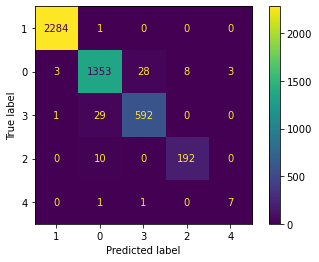

[CV 1/10] END activation=relu, learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.986 total time= 1.7min
[CV 7/10] END activation=relu, learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.988 total time= 1.5min
[CV 2/10] END activation=relu, learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.987 total time= 1.1min
[CV 6/10] END activation=relu, learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.991 total time= 1.2min
[CV 8/10] END activation=relu, learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.991 total time= 1.4min
[CV 3/10] END activation=relu, learning_rate=adaptive, max_iter=400, solver=adam, warm_start=True;, score=0.988 total time= 1.3min
[CV 8/10] END activation=relu, learning_rate=adaptive, max_iter=400, solver=adam, warm_start=True;, score=0.991 total time= 1.3min
[CV 2/10] END activation=tanh, learning_rate=constant, max_iter=400, solver=a

In [148]:
read = open('SVM_Linear_1_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.2 SVM QUADRATIC</font>

In [23]:
file_exists = os.path.exists('SVM_Quad_1_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_1_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 133.1907138824463
SVC(C=1000, degree=2, kernel='poly')
0.9860928008549792
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[2276    1    0    1    0]
 [   5 1340   19    4    2]
 [   0   15  653    0    3]
 [   0    6    0  182    0]
 [   0    0    1    0    5]]

% of Correctly classified instances:  0.9874
% of Incorrectly classified instances:  0.0126

Accuracy 0.9874
Precision (Weighted): 0.9878
Precision (Micro): 0.9874
Precision (Macro): 0.885
Recall (Weighted) 0.9874
Recall (Micro) 0.9874
Recall (Macro) 0.9504
F1 Score: 0.9875
F1 Score (Micro): 0.9874
F1 Score (Macro): 0.9094
Geometric Mean: 0.985

Train Time(s) 3.189749002456665
Test Time(s) 0.6521830558776855


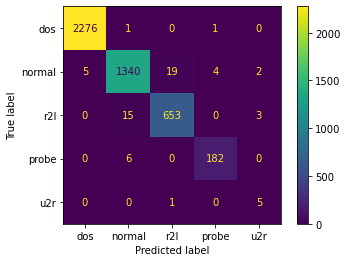

In [24]:
read = open('SVM_Quad_1_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.3 SVM CUBIC</font>

In [25]:
file_exists = os.path.exists('SVM_Cubic_1_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_1_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 123.93817210197449
SVC(C=1000, kernel='poly')
0.9872010183587104
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[2277    0    0    1    0]
 [   2 1350   14    2    2]
 [   0   17  652    0    2]
 [   0    6    0  182    0]
 [   0    0    1    0    5]]

% of Correctly classified instances:  0.9896
% of Incorrectly classified instances:  0.0104

Accuracy 0.9896
Precision (Weighted): 0.9899
Precision (Micro): 0.9896
Precision (Macro): 0.8998
Recall (Weighted) 0.9896
Recall (Micro) 0.9896
Recall (Macro) 0.9516
F1 Score: 0.9897
F1 Score (Micro): 0.9896
F1 Score (Macro): 0.9202
Geometric Mean: 0.9882

Train Time(s) 2.366213083267212
Test Time(s) 0.32512998580932617


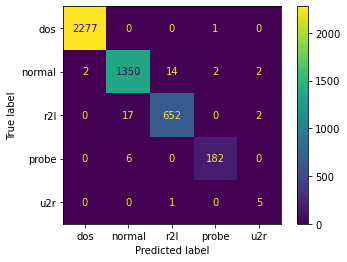

In [26]:
read = open('SVM_Cubic_1_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.4 KNN FINE</font>

In [30]:
file_exists = os.path.exists('KNN_Fine_1_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_1_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 163.12614917755127
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9868683012818543
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[2274    4    0    0    0]
 [  13 1331   22    0    4]
 [   1   24  646    0    0]
 [   4   11    1  172    0]
 [   0    0    2    0    4]]

% of Correctly classified instances:  0.9809
% of Incorrectly classified instances:  0.0191

Accuracy 0.9809
Precision (Weighted): 0.9812
Precision (Micro): 0.9809
Precision (Macro): 0.8853
Recall (Weighted) 0.9809
Recall (Micro) 0.9809
Recall (Macro) 0.9028
F1 Score: 0.981
F1 Score (Micro): 0.9809
F1 Score (Macro): 0.8913
Geometric Mean: 0.9749

Train Time(s) 0.038301944732666016
Test Time(s) 0.7683818340301514


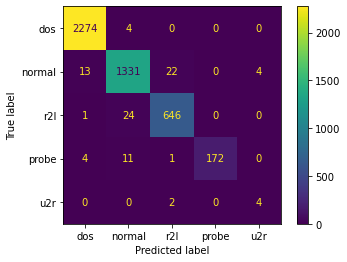

In [31]:
read = open('KNN_Fine_1_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.5 KNN MEDIUM</font>

In [36]:
file_exists = os.path.exists('KNN_Medium_1_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_1_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 140.7197229862213
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9829341383567449
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[2274    4    0    0    0]
 [  13 1331   22    0    4]
 [   1   24  646    0    0]
 [   4   11    1  172    0]
 [   0    0    2    0    4]]

% of Correctly classified instances:  0.9809
% of Incorrectly classified instances:  0.0191

Accuracy 0.9809
Precision (Weighted): 0.9812
Precision (Micro): 0.9809
Precision (Macro): 0.8853
Recall (Weighted) 0.9809
Recall (Micro) 0.9809
Recall (Macro) 0.9028
F1 Score: 0.981
F1 Score (Micro): 0.9809
F1 Score (Macro): 0.8913
Geometric Mean: 0.9749

Train Time(s) 0.04135394096374512
Test Time(s) 0.8409531116485596


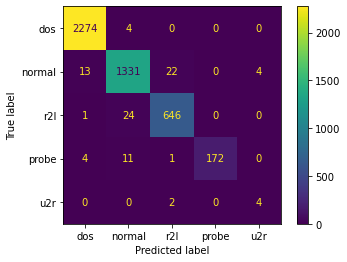

In [37]:
read = open('KNN_Medium_1_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.6 KNN CUBIC</font>

In [38]:
file_exists = os.path.exists('KNN_Cubic_1_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_1_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 1170.864511013031
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.9824908329289789
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[2274    4    0    0    0]
 [  13 1331   22    0    4]
 [   1   24  646    0    0]
 [   4   11    1  172    0]
 [   0    0    2    0    4]]

% of Correctly classified instances:  0.9809
% of Incorrectly classified instances:  0.0191

Accuracy 0.9809
Precision (Weighted): 0.9812
Precision (Micro): 0.9809
Precision (Macro): 0.8853
Recall (Weighted) 0.9809
Recall (Micro) 0.9809
Recall (Macro) 0.9028
F1 Score: 0.981
F1 Score (Micro): 0.9809
F1 Score (Macro): 0.8913
Geometric Mean: 0.9749

Train Time(s) 0.0382537841796875
Test Time(s) 0.7394387722015381


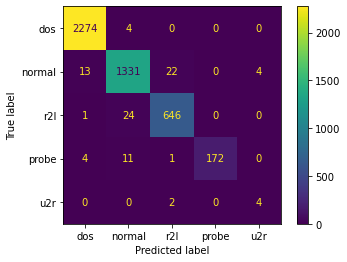

In [39]:
read = open('KNN_Cubic_1_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.7 TREE MEDIUM</font>

In [40]:
file_exists = os.path.exists('Tree_Medium_1_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_1_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 3/10] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.988 total time=   7.1s
[CV 5/10] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.986 total time=   7.3s
[CV 10/10] END algorithm=ball_tree, leaf_size=10, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.985 total time=  10.4s
[CV 4/10] END algorithm=ball_tree, leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.986 total time=  11.2s
[CV 8/10] END algorithm=ball_tree, leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.989 total time=  10.2s
[CV 2/10] END algorithm=ball_tree, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.991 total time=   8.7s
[CV 6/10] END algorithm=ball_tree, leaf_size=30, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=

0

Confusion Matrix Raw Format:
 [[2270    2    0    6    0]
 [   2 1328   31    6    3]
 [   1   28  640    1    1]
 [   2   14    1  171    0]
 [   1    0    1    0    4]]

% of Correctly classified instances:  0.9778
% of Incorrectly classified instances:  0.0222

Accuracy 0.9778
Precision (Weighted): 0.978
Precision (Micro): 0.9778
Precision (Macro): 0.8691
Recall (Weighted) 0.9778
Recall (Micro) 0.9778
Recall (Macro) 0.8992
F1 Score: 0.9779
F1 Score (Micro): 0.9778
F1 Score (Macro): 0.8817
Geometric Mean: 0.9744

Train Time(s) 0.055989980697631836
Test Time(s) 0.005918979644775391


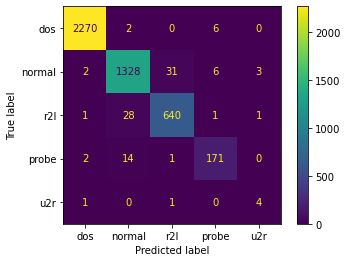

In [41]:
read = open('Tree_Medium_1_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>1.8 TREE FINE</font>

In [42]:
file_exists = os.path.exists('Tree_Fine_1_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_1_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 10/10] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=20, random_state=42, splitter=random;, score=0.968 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.984 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.985 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.980 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.979 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.982 total time=   0.1s
[CV 4/10] END criterion=gini, m

0

Confusion Matrix Raw Format:
 [[2269    2    1    6    0]
 [   3 1344   15    7    1]
 [   0   52  616    3    0]
 [   2   19    0  167    0]
 [   0    5    1    0    0]]

% of Correctly classified instances:  0.9741
% of Incorrectly classified instances:  0.0259

Accuracy 0.9741
Precision (Weighted): 0.9733
Precision (Micro): 0.9741
Precision (Macro): 0.7657
Recall (Weighted) 0.9741
Recall (Micro) 0.9741
Recall (Macro) 0.7567
F1 Score: 0.9734
F1 Score (Micro): 0.9741
F1 Score (Macro): 0.7609
Geometric Mean: 0.9705

Train Time(s) 0.05672812461853027
Test Time(s) 0.008700847625732422


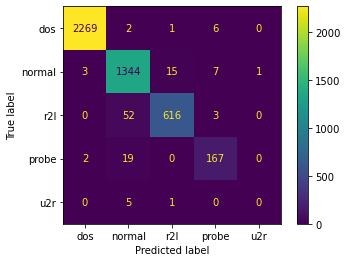

In [43]:
read = open('Tree_Fine_1_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 2</font>
#### Below, 8 algorithms are being fitted on 113 features with 70:30 split. Protocol_Type, Flag and Service have been one-hot encloded.
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

## <font color=Blue> 70:30 SPLIT for RUN NO. 2</font>

In [44]:
# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

(15792, 113) (15792,)
(6769, 113) (6769,)


## <font color='blue'>2.1 SVM LINEAR</font>

In [45]:
file_exists = os.path.exists('SVM_Linear_2_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_2_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 126.37588405609131
SVC(C=1000, kernel='linear')
0.9784708315629984
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Confusion Matrix Raw Format:
 [[3498    8    0    0    0]
 [   7 1982   50   14    1]
 [   1   44  855    1    0]
 [   1   11    0  285    0]
 [   0    1    2    0    8]]

% of Correctly classified instances:  0.9792
% of Incorrectly classified instances:  0.0208

Accuracy 0.9792
Precision (Weighted): 0.9792
Precision (Micro): 0.9792
Precision (Macro): 0.9495
Recall (Weighted) 0.9792
Recall (Micro) 0.9792
Recall (Macro) 0.9197
F1 Score: 0.9792
F1 Score (Micro): 0.9792
F1 Score (Macro): 0.933
Geometric Mean: 0.9757

Train Time(s) 11.978040218353271
Test Time(s) 0.4058971405029297


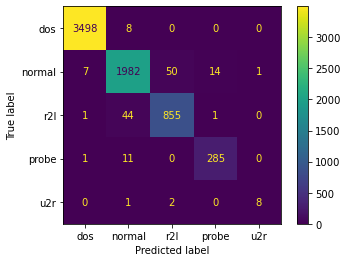

In [46]:
read = open('SVM_Linear_2_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.2 SVM QUADRATIC</font>

In [47]:
file_exists = os.path.exists('SVM_Quad_2_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_2_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 83.72341299057007
SVC(C=1000, degree=2, kernel='poly')
0.9849927048845208
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3503    1    0    2    0]
 [   5 2007   35    2    5]
 [   0   26  874    0    1]
 [   0   10    0  287    0]
 [   0    3    3    0    5]]

% of Correctly classified instances:  0.9863
% of Incorrectly classified instances:  0.0137

Accuracy 0.9863
Precision (Weighted): 0.9863
Precision (Micro): 0.9863
Precision (Macro): 0.8756
Recall (Weighted) 0.9863
Recall (Micro) 0.9863
Recall (Macro) 0.8734
F1 Score: 0.9863
F1 Score (Micro): 0.9863
F1 Score (Macro): 0.8745
Geometric Mean: 0.9848

Train Time(s) 1.9265530109405518
Test Time(s) 0.3566420078277588


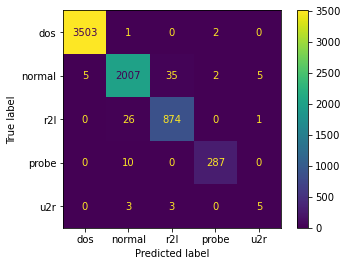

In [48]:
read = open('SVM_Quad_2_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.3 SVM CUBIC</font>

In [49]:
file_exists = os.path.exists('SVM_Cubic_2_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_2_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 81.99531412124634
SVC(C=1000, kernel='poly')
0.9869558525264349
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3502    2    0    2    0]
 [   5 2014   28    2    5]
 [   0   22  877    0    2]
 [   0    8    0  289    0]
 [   0    3    3    0    5]]

% of Correctly classified instances:  0.9879
% of Incorrectly classified instances:  0.0121

Accuracy 0.9879
Precision (Weighted): 0.988
Precision (Micro): 0.9879
Precision (Macro): 0.8701
Recall (Weighted) 0.9879
Recall (Micro) 0.9879
Recall (Macro) 0.8761
F1 Score: 0.9879
F1 Score (Micro): 0.9879
F1 Score (Macro): 0.8729
Geometric Mean: 0.9865

Train Time(s) 1.924346923828125
Test Time(s) 0.36823296546936035


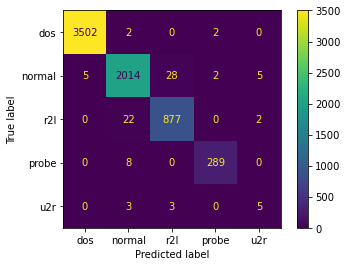

In [50]:
read = open('SVM_Cubic_2_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.4 KNN FINE</font>

In [51]:
file_exists = os.path.exists('KNN_Fine_2_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_2_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 118.18436598777771
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9866389959997115
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3495   11    0    0    0]
 [  19 1985   46    2    2]
 [   1   27  872    0    1]
 [   7   11    0  279    0]
 [   0    2    5    0    4]]

% of Correctly classified instances:  0.9802
% of Incorrectly classified instances:  0.0198

Accuracy 0.9802
Precision (Weighted): 0.9801
Precision (Micro): 0.9802
Precision (Macro): 0.8953
Recall (Weighted) 0.9802
Recall (Micro) 0.9802
Recall (Macro) 0.8468
F1 Score: 0.98
F1 Score (Micro): 0.9802
F1 Score (Macro): 0.8662
Geometric Mean: 0.9743

Train Time(s) 0.03442025184631348
Test Time(s) 0.9074068069458008


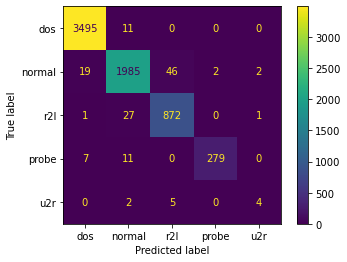

In [52]:
read = open('KNN_Fine_2_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.5 KNN MEDIUM</font>

In [53]:
file_exists = os.path.exists('KNN_Medium_2_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_2_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 89.23771500587463
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9821431606288229
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3495   11    0    0    0]
 [  19 1985   46    2    2]
 [   1   27  872    0    1]
 [   7   11    0  279    0]
 [   0    2    5    0    4]]

% of Correctly classified instances:  0.9802
% of Incorrectly classified instances:  0.0198

Accuracy 0.9802
Precision (Weighted): 0.9801
Precision (Micro): 0.9802
Precision (Macro): 0.8953
Recall (Weighted) 0.9802
Recall (Micro) 0.9802
Recall (Macro) 0.8468
F1 Score: 0.98
F1 Score (Micro): 0.9802
F1 Score (Macro): 0.8662
Geometric Mean: 0.9743

Train Time(s) 0.0333709716796875
Test Time(s) 0.9057378768920898


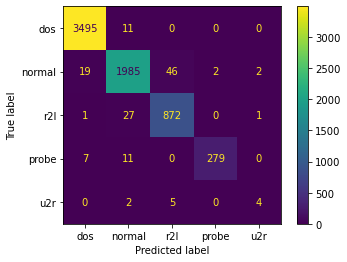

In [54]:
read = open('KNN_Medium_2_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.6 KNN CUBIC</font>

In [55]:
file_exists = os.path.exists('KNN_Cubic_2_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_2_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 10/10] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=100, random_state=42, splitter=random;, score=0.927 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=best;, score=0.969 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=best;, score=0.969 total time=   0.1s
[CV 5/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.967 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.957 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.970 total time=   0.1s
[CV 4/10] END criterion=gini, ma

0

Confusion Matrix Raw Format:
 [[3495   11    0    0    0]
 [  19 1985   46    2    2]
 [   1   27  872    0    1]
 [   7   11    0  279    0]
 [   0    2    5    0    4]]

% of Correctly classified instances:  0.9802
% of Incorrectly classified instances:  0.0198

Accuracy 0.9802
Precision (Weighted): 0.9801
Precision (Micro): 0.9802
Precision (Macro): 0.8953
Recall (Weighted) 0.9802
Recall (Micro) 0.9802
Recall (Macro) 0.8468
F1 Score: 0.98
F1 Score (Micro): 0.9802
F1 Score (Macro): 0.8662
Geometric Mean: 0.9743

Train Time(s) 0.038877010345458984
Test Time(s) 0.9087891578674316


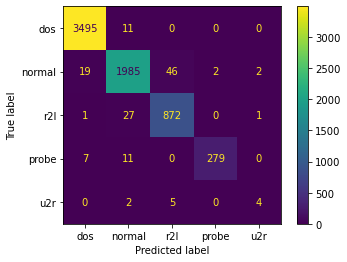

In [56]:
read = open('KNN_Cubic_2_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.7 TREE MEDIUM</font>

In [57]:
file_exists = os.path.exists('Tree_Medium_2_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_2_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 6/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=best;, score=0.955 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.968 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.967 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.957 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.962 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.962 total time=   0.1s
[CV 10/10] END criterion=gini, 

0

Confusion Matrix Raw Format:
 [[3473   23    4    6    0]
 [  14 2002   24   12    2]
 [   0   44  855    0    2]
 [   3   10    5  279    0]
 [   0    6    2    0    3]]

% of Correctly classified instances:  0.9768
% of Incorrectly classified instances:  0.0232

Accuracy 0.9768
Precision (Weighted): 0.9766
Precision (Micro): 0.9768
Precision (Macro): 0.8568
Recall (Weighted) 0.9768
Recall (Micro) 0.9768
Recall (Macro) 0.8253
F1 Score: 0.9766
F1 Score (Micro): 0.9768
F1 Score (Macro): 0.8375
Geometric Mean: 0.9697

Train Time(s) 0.04506707191467285
Test Time(s) 0.010461807250976562


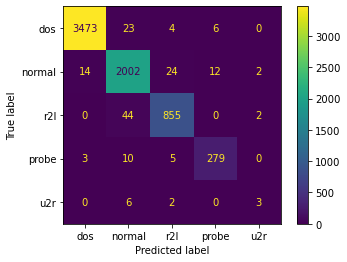

In [58]:
read = open('Tree_Medium_2_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>2.8 TREE FINE</font>

In [59]:
file_exists = os.path.exists('Tree_Fine_2_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_2_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.849 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.863 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.806 total time=   0.1s
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.788 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.864 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.887 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=5

0

Confusion Matrix Raw Format:
 [[3453   21    7   25    0]
 [  11 1980   56    6    1]
 [   0   69  831    0    1]
 [  10   26    8  252    1]
 [   0    6    4    0    1]]

% of Correctly classified instances:  0.9628
% of Incorrectly classified instances:  0.0372

Accuracy 0.9628
Precision (Weighted): 0.9622
Precision (Micro): 0.9628
Precision (Macro): 0.7987
Recall (Weighted) 0.9628
Recall (Micro) 0.9628
Recall (Macro) 0.7621
F1 Score: 0.9624
F1 Score (Micro): 0.9628
F1 Score (Macro): 0.7729
Geometric Mean: 0.9545

Train Time(s) 0.04737424850463867
Test Time(s) 0.007925987243652344


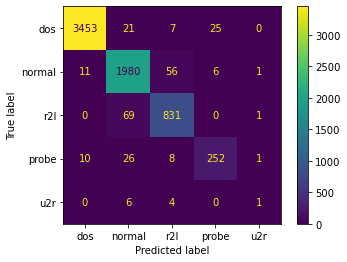

In [60]:
read = open('Tree_Fine_2_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 3</font>
#### Below, 8 algorithms are being fitted on 104 features with 80:20 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with corr > 0.9 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [61]:
NSLKDD_DF_RUN3 = NSLKDD_DF.copy()

# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN3.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSLKDD_DF_RUN3)
# Drop all correlated features
NSLKDD_DF_RUN3.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN3.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN3['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN3.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN3

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 106)
(18048, 104) (18048,)
(4513, 104) (4513,)


## <font color='blue'>3.1 SVM LINEAR</font>

In [62]:
file_exists = os.path.exists('SVM_Linear_3_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_3_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=17, splitter=best;, score=0.877 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.824 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.785 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.807 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.845 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.864 total time=   0.1s
[CV 2/10] END criterion=gini, max_dept

0

Confusion Matrix Raw Format:
 [[1305    7    2   32    1]
 [   1 2325    0    0    0]
 [  12    1  179    0    0]
 [  29    0    0  604    2]
 [   2    1    0    3    7]]

% of Correctly classified instances:  0.9794
% of Incorrectly classified instances:  0.0206

Accuracy 0.9794
Precision (Weighted): 0.9792
Precision (Micro): 0.9794
Precision (Macro): 0.9195
Recall (Weighted) 0.9794
Recall (Micro) 0.9794
Recall (Macro) 0.8781
F1 Score: 0.9792
F1 Score (Micro): 0.9794
F1 Score (Macro): 0.8965
Geometric Mean: 0.9767

Train Time(s) 11.457720041275024
Test Time(s) 0.24877214431762695


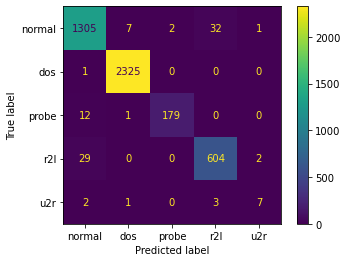

In [63]:
read = open('SVM_Linear_3_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.2 SVM QUADRATIC</font>

In [64]:
file_exists = os.path.exists('SVM_Quad_3_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_3_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 99.70379900932312
SVC(C=1000, degree=2, kernel='poly')
0.9842640546400429
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[1308    8    2   29    0]
 [   4 2322    0    0    0]
 [   1    1  190    0    0]
 [  23    0    0  610    2]
 [   4    0    0    1    8]]

% of Correctly classified instances:  0.9834
% of Incorrectly classified instances:  0.0166

Accuracy 0.9834
Precision (Weighted): 0.9833
Precision (Micro): 0.9834
Precision (Macro): 0.943
Recall (Weighted) 0.9834
Recall (Micro) 0.9834
Recall (Macro) 0.907
F1 Score: 0.9833
F1 Score (Micro): 0.9834
F1 Score (Macro): 0.9226
Geometric Mean: 0.9794

Train Time(s) 3.0480949878692627
Test Time(s) 0.22150301933288574


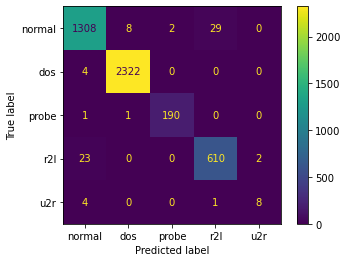

In [65]:
read = open('SVM_Quad_3_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.3 SVM CUBIC</font>

In [66]:
file_exists = os.path.exists('SVM_Cubic_3_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_3_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 95.93466687202454
SVC(C=1000, kernel='poly')
0.9868128074884375
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[1322    5    1   18    1]
 [   3 2323    0    0    0]
 [   1    0  191    0    0]
 [  20    0    0  613    2]
 [   4    0    0    1    8]]

% of Correctly classified instances:  0.9876
% of Incorrectly classified instances:  0.0124

Accuracy 0.9876
Precision (Weighted): 0.9875
Precision (Micro): 0.9876
Precision (Macro): 0.9338
Recall (Weighted) 0.9876
Recall (Micro) 0.9876
Recall (Macro) 0.9111
F1 Score: 0.9875
F1 Score (Micro): 0.9876
F1 Score (Macro): 0.9215
Geometric Mean: 0.9851

Train Time(s) 2.708585262298584
Test Time(s) 0.23209285736083984


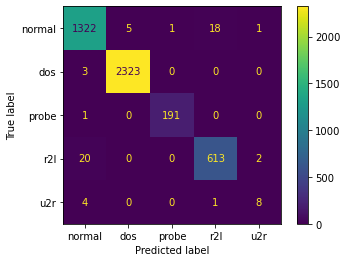

In [67]:
read = open('SVM_Cubic_3_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.4 KNN FINE</font>

In [68]:
file_exists = os.path.exists('KNN_Fine_3_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_3_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 129.15712571144104
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9859815675844998
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[1305   12    0   27    3]
 [   6 2320    0    0    0]
 [   1    3  188    0    0]
 [  10    1    0  622    2]
 [   2    0    0    1   10]]

% of Correctly classified instances:  0.9849
% of Incorrectly classified instances:  0.0151

Accuracy 0.9849
Precision (Weighted): 0.9852
Precision (Micro): 0.9849
Precision (Macro): 0.9205
Recall (Weighted) 0.9849
Recall (Micro) 0.9849
Recall (Macro) 0.9388
F1 Score: 0.985
F1 Score (Micro): 0.9849
F1 Score (Macro): 0.9289
Geometric Mean: 0.9794

Train Time(s) 0.19707727432250977
Test Time(s) 8.160434007644653


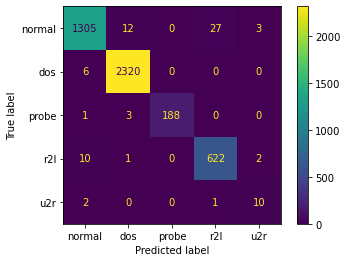

In [69]:
read = open('KNN_Fine_3_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.5 KNN MEDIUM</font>

In [70]:
file_exists = os.path.exists('KNN_Medium_3_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_3_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 105.30241584777832
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9807731971426993
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[1297   24    0   26    0]
 [   8 2318    0    0    0]
 [   4    4  184    0    0]
 [  12    1    0  621    1]
 [   1    0    0    5    7]]

% of Correctly classified instances:  0.9809
% of Incorrectly classified instances:  0.0191

Accuracy 0.9809
Precision (Weighted): 0.9809
Precision (Micro): 0.9809
Precision (Macro): 0.9592
Recall (Weighted) 0.9809
Recall (Micro) 0.9809
Recall (Macro) 0.8868
F1 Score: 0.9807
F1 Score (Micro): 0.9809
F1 Score (Macro): 0.9149
Geometric Mean: 0.9722

Train Time(s) 0.19381213188171387
Test Time(s) 10.307424068450928


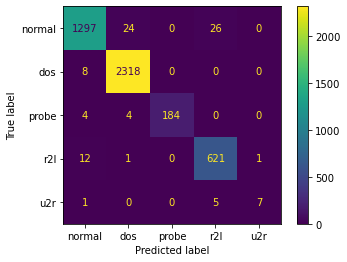

In [71]:
read = open('KNN_Medium_3_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.6 KNN CUBIC</font>

In [72]:
file_exists = os.path.exists('KNN_Cubic_3_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_3_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 925.7659890651703
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.9807731971426993
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[1301   21    0   25    0]
 [   8 2318    0    0    0]
 [   5    4  183    0    0]
 [  13    1    0  620    1]
 [   1    0    0    5    7]]

% of Correctly classified instances:  0.9814
% of Incorrectly classified instances:  0.0186

Accuracy 0.9814
Precision (Weighted): 0.9814
Precision (Micro): 0.9814
Precision (Macro): 0.9595
Recall (Weighted) 0.9814
Recall (Micro) 0.9814
Recall (Macro) 0.8861
F1 Score: 0.9812
F1 Score (Micro): 0.9814
F1 Score (Macro): 0.9146
Geometric Mean: 0.9734

Train Time(s) 0.555793285369873
Test Time(s) 70.18794703483582


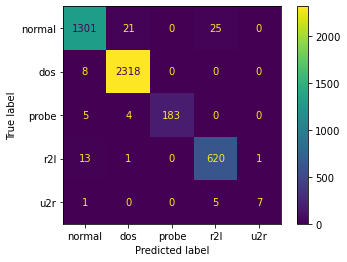

In [73]:
read = open('KNN_Cubic_3_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.7 TREE MEDIUM</font>

In [74]:
file_exists = os.path.exists('Tree_Medium_3_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_3_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 9/10] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=100, random_state=42, splitter=random;, score=0.958 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=30, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.960 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=30, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.960 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=30, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.963 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=30, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.965 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=30, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.966 total time=   0.1s
[CV 4/10] END criterion=gi

0

Confusion Matrix Raw Format:
 [[1323    5    6   13    0]
 [   7 2315    3    1    0]
 [  13    1  178    0    0]
 [  16    0    1  615    3]
 [   3    1    0    5    4]]

% of Correctly classified instances:  0.9827
% of Incorrectly classified instances:  0.0173

Accuracy 0.9827
Precision (Weighted): 0.9822
Precision (Micro): 0.9827
Precision (Macro): 0.8913
Recall (Weighted) 0.9827
Recall (Micro) 0.9827
Recall (Macro) 0.8361
F1 Score: 0.9823
F1 Score (Micro): 0.9827
F1 Score (Macro): 0.8558
Geometric Mean: 0.9799

Train Time(s) 0.052945852279663086
Test Time(s) 0.009348869323730469


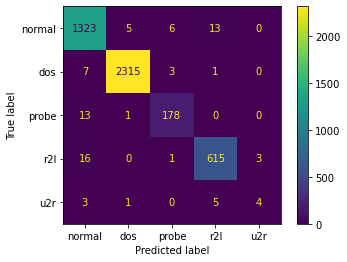

In [75]:
read = open('Tree_Medium_3_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>3.8 TREE FINE</font>

In [76]:
file_exists = os.path.exists('Tree_Fine_3_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_3_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 2/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.911 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.896 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.906 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.961 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.948 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=20, random_state=17, splitter=random;, score=0.871 total time=   0.1s
[CV 5/10] END criterion=gini, ma

0

Confusion Matrix Raw Format:
 [[1293   13   20   21    0]
 [   0 2320    6    0    0]
 [   7    6  179    0    0]
 [  32    0    3  599    1]
 [   4    0    1    3    5]]

% of Correctly classified instances:  0.9741
% of Incorrectly classified instances:  0.0259

Accuracy 0.9741
Precision (Weighted): 0.9742
Precision (Micro): 0.9741
Precision (Macro): 0.9222
Recall (Weighted) 0.9741
Recall (Micro) 0.9741
Recall (Macro) 0.8435
F1 Score: 0.9738
F1 Score (Micro): 0.9741
F1 Score (Macro): 0.866
Geometric Mean: 0.9702

Train Time(s) 0.05217719078063965
Test Time(s) 0.010877847671508789


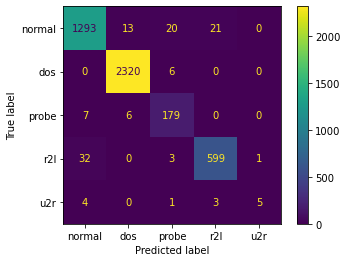

In [77]:
read = open('Tree_Fine_3_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 4</font>
#### Below, 8 algorithms are being fitted on 104 features with 70:30 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with corr > 0.9 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [78]:
NSLKDD_DF_RUN4 = NSLKDD_DF.copy()

# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN4.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSLKDD_DF_RUN4)
# Drop all correlated features
NSLKDD_DF_RUN4.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN4.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN4['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN4.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN4

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 106)
(15792, 104) (15792,)
(6769, 104) (6769,)


## <font color='blue'>4.1 SVM LINEAR</font>

In [79]:
file_exists = os.path.exists('SVM_Linear_4_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_4_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 122.78860902786255
SVC(C=1000, kernel='linear')
0.9766336649537841
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Confusion Matrix Raw Format:
 [[3414    0    1    0    0]
 [   0  877   42    4    0]
 [  24   53 2032    2    5]
 [   0    4    7    5    0]
 [   2    0   13    0  284]]

% of Correctly classified instances:  0.9768
% of Incorrectly classified instances:  0.0232

Accuracy 0.9768
Precision (Weighted): 0.9764
Precision (Micro): 0.9768
Precision (Macro): 0.8677
Recall (Weighted) 0.9768
Recall (Micro) 0.9768
Recall (Macro) 0.8345
F1 Score: 0.9765
F1 Score (Micro): 0.9768
F1 Score (Macro): 0.8484
Geometric Mean: 0.9714

Train Time(s) 8.756192207336426
Test Time(s) 0.32611799240112305


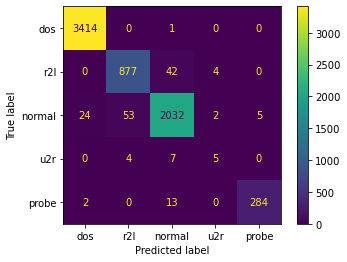

In [80]:
read = open('SVM_Linear_4_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.2 SVM QUAD</font>

In [81]:
file_exists = os.path.exists('SVM_Quad_4_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_4_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 78.66046905517578
SVC(C=1000, degree=2, kernel='poly')
0.9833459728557571
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3414    0    1    0    0]
 [   0  893   27    3    0]
 [  18   48 2040    5    5]
 [   1    2    6    7    0]
 [   8    0    7    0  284]]

% of Correctly classified instances:  0.9806
% of Incorrectly classified instances:  0.0194

Accuracy 0.9806
Precision (Weighted): 0.9806
Precision (Micro): 0.9806
Precision (Macro): 0.8738
Recall (Weighted) 0.9806
Recall (Micro) 0.9806
Recall (Macro) 0.8637
F1 Score: 0.9806
F1 Score (Micro): 0.9806
F1 Score (Macro): 0.8686
Geometric Mean: 0.9758

Train Time(s) 2.1643171310424805
Test Time(s) 0.29965901374816895


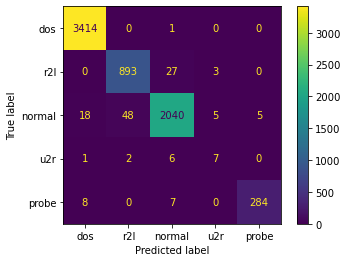

In [82]:
read = open('SVM_Quad_4_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.3 SVM CUBIC</font>

In [83]:
file_exists = os.path.exists('SVM_Cubic_4_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_4_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 76.22674369812012
SVC(C=1000, kernel='poly')
0.9853723715538596
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3414    0    1    0    0]
 [   0  898   22    3    0]
 [  12   41 2056    6    1]
 [   2    3    5    6    0]
 [   3    0    6    0  290]]

% of Correctly classified instances:  0.9845
% of Incorrectly classified instances:  0.0155

Accuracy 0.9845
Precision (Weighted): 0.9845
Precision (Micro): 0.9845
Precision (Macro): 0.8657
Recall (Weighted) 0.9845
Recall (Micro) 0.9845
Recall (Macro) 0.8578
F1 Score: 0.9844
F1 Score (Micro): 0.9845
F1 Score (Macro): 0.8616
Geometric Mean: 0.9812

Train Time(s) 2.165955066680908
Test Time(s) 0.31133174896240234


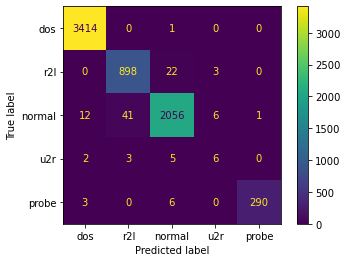

In [84]:
read = open('SVM_Cubic_4_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.4 KNN FINE</font>

In [85]:
file_exists = os.path.exists('KNN_Fine_4_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_4_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 3/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=100, random_state=42, splitter=random;, score=0.899 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=100, random_state=42, splitter=random;, score=0.902 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.943 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.951 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.929 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.946 total time=   0.1s
[CV 7/10] END criterion=gini, max_

0

Confusion Matrix Raw Format:
 [[3412    0    3    0    0]
 [   0  911   10    2    0]
 [  11   40 2057    3    5]
 [   1    3    3    9    0]
 [   7    1    5    0  286]]

% of Correctly classified instances:  0.9861
% of Incorrectly classified instances:  0.0139

Accuracy 0.9861
Precision (Weighted): 0.9862
Precision (Micro): 0.9861
Precision (Macro): 0.9128
Recall (Weighted) 0.9861
Recall (Micro) 0.9861
Recall (Macro) 0.8955
F1 Score: 0.9861
F1 Score (Micro): 0.9861
F1 Score (Macro): 0.9035
Geometric Mean: 0.9826

Train Time(s) 0.15685606002807617
Test Time(s) 10.154952049255371


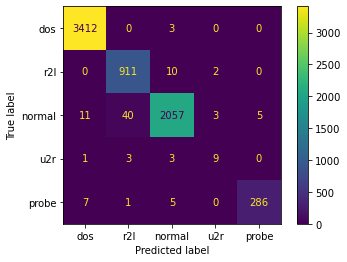

In [86]:
read = open('KNN_Fine_4_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.5 KNN MEDIUM</font>

In [87]:
file_exists = os.path.exists('KNN_Medium_4_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_4_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 78.66120195388794
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9804332577099751
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3407    0    8    0    0]
 [   0  908   13    2    0]
 [  38   51 2021    4    2]
 [   1    3    9    3    0]
 [  12    1    6    0  280]]

% of Correctly classified instances:  0.9778
% of Incorrectly classified instances:  0.0222

Accuracy 0.9778
Precision (Weighted): 0.9774
Precision (Micro): 0.9778
Precision (Macro): 0.8474
Recall (Weighted) 0.9778
Recall (Micro) 0.9778
Recall (Macro) 0.8121
F1 Score: 0.9774
F1 Score (Micro): 0.9778
F1 Score (Macro): 0.8254
Geometric Mean: 0.9685

Train Time(s) 0.23148512840270996
Test Time(s) 12.813874959945679


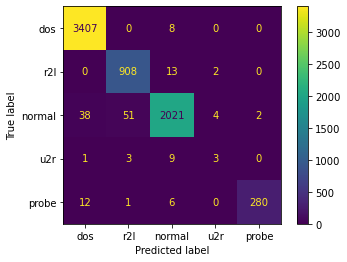

In [88]:
read = open('KNN_Medium_4_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.6 KNN CUBIC</font>

In [89]:
file_exists = os.path.exists('KNN_Cubic_4_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_4_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 822.0721049308777
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.9801799729038567
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3407    0    8    0    0]
 [   0  907   14    2    0]
 [  39   48 2024    3    2]
 [   1    3    8    4    0]
 [  12    2    5    0  280]]

% of Correctly classified instances:  0.9783
% of Incorrectly classified instances:  0.0217

Accuracy 0.9783
Precision (Weighted): 0.9779
Precision (Micro): 0.9783
Precision (Macro): 0.87
Recall (Weighted) 0.9783
Recall (Micro) 0.9783
Recall (Macro) 0.8247
F1 Score: 0.9779
F1 Score (Micro): 0.9783
F1 Score (Macro): 0.8416
Geometric Mean: 0.9689

Train Time(s) 0.6714682579040527
Test Time(s) 91.27130317687988


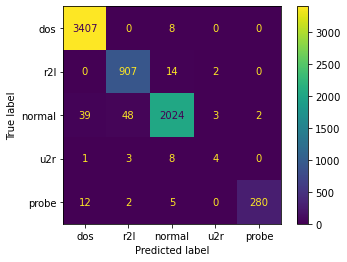

In [90]:
read = open('KNN_Cubic_4_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.7 TREE MEDIUM</font>

In [91]:
file_exists = os.path.exists('Tree_Medium_4_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_4_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 3/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=best;, score=0.967 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=best;, score=0.966 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=random;, score=0.957 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=random;, score=0.947 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=random;, score=0.958 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=35, max_features=log2, min_samples_split=100, random_state=42, splitter=random;, score=0.956 total time=   0.1s
[CV 7/10] END criterion=gi

0

Confusion Matrix Raw Format:
 [[3404    0    6    0    5]
 [   0  882   33    4    4]
 [   4   31 2077    3    1]
 [   0    0   10    6    0]
 [  15    1   15    0  268]]

% of Correctly classified instances:  0.9805
% of Incorrectly classified instances:  0.0195

Accuracy 0.9805
Precision (Weighted): 0.9802
Precision (Micro): 0.9805
Precision (Macro): 0.871
Recall (Weighted) 0.9805
Recall (Micro) 0.9805
Recall (Macro) 0.841
F1 Score: 0.9803
F1 Score (Micro): 0.9805
F1 Score (Macro): 0.8549
Geometric Mean: 0.977

Train Time(s) 0.05673408508300781
Test Time(s) 0.007838964462280273


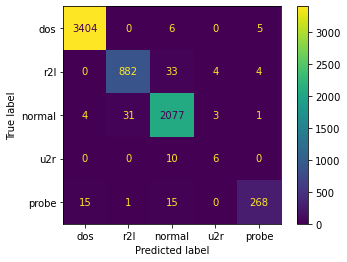

In [92]:
read = open('Tree_Medium_4_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>4.8 TREE FINE</font>

In [93]:
file_exists = os.path.exists('Tree_Fine_4_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_4_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 9/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.958 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.944 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=17, splitter=random;, score=0.899 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=17, splitter=random;, score=0.963 total time=   0.1s
[CV 5/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=42, splitter=best;, score=0.963 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=15, max_features=log2, min_samples_split=20, random_state=42, splitter=best;, score=0.962 total time=   0.1s
[CV 3/10] END criterion=gini, max_de

0

Confusion Matrix Raw Format:
 [[3385    0   19    0   11]
 [   1  857   63    2    0]
 [  13   26 2064    1   12]
 [   1    3   11    1    0]
 [  13    0   20    0  266]]

% of Correctly classified instances:  0.971
% of Incorrectly classified instances:  0.029

Accuracy 0.971
Precision (Weighted): 0.9699
Precision (Micro): 0.971
Precision (Macro): 0.8155
Recall (Weighted) 0.971
Recall (Micro) 0.971
Recall (Macro) 0.7695
F1 Score: 0.9702
F1 Score (Micro): 0.971
F1 Score (Macro): 0.7811
Geometric Mean: 0.9628

Train Time(s) 0.05199790000915527
Test Time(s) 0.0075452327728271484


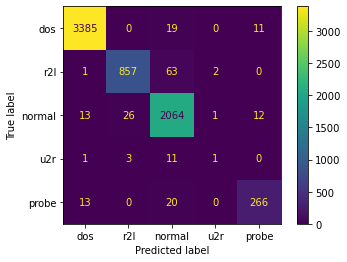

In [94]:
read = open('Tree_Fine_4_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 5</font>
#### Below, 8 algorithms are being fitted on 71 features with 80:20 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with VIF > 10 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [18]:
NSLKDD_DF_RUN5 = NSLKDD_DF.copy()
NSLKDD_DF_RUN5_temp = NSLKDD_DF_RUN5.drop(['attack_category','attack_type'], axis=1)
# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN5.shape)

#Pass dataframe to the VIF method
VIF_col_list = VIF(NSLKDD_DF_RUN5_temp)
# Drop all features returned by VIF
NSLKDD_DF_RUN5.drop(labels=VIF_col_list, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN5.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN5['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN5.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN5, NSLKDD_DF_RUN5_temp

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 73)
(15792, 71) (15792,)
(6769, 71) (6769,)


## <font color='blue'>5.1 SVM LINEAR</font>

In [98]:
file_exists = os.path.exists('SVM_Linear_5_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_5_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 319.2239770889282
SVC(C=1000, kernel='linear')
0.9090046977337043
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Confusion Matrix Raw Format:
 [[3382   43    2    4    0]
 [  80 1876   76   64    3]
 [   7  269  660    2    0]
 [  10   34    6  233    0]
 [   2    4    2    0   10]]

% of Correctly classified instances:  0.9102
% of Incorrectly classified instances:  0.0898

Accuracy 0.9102
Precision (Weighted): 0.9106
Precision (Micro): 0.9102
Precision (Macro): 0.8475
Recall (Weighted) 0.9102
Recall (Micro) 0.9102
Recall (Macro) 0.7924
F1 Score: 0.9086
F1 Score (Micro): 0.9102
F1 Score (Macro): 0.8141
Geometric Mean: 0.8916

Train Time(s) 25.980195999145508
Test Time(s) 1.213644027709961


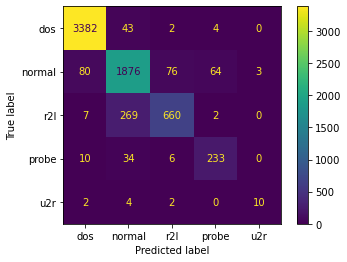

In [99]:
read = open('SVM_Linear_5_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.2 SVM QUAD</font>

In [19]:
file_exists = os.path.exists('SVM_Quad_5_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_5_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 195.87263202667236
SVC(C=1000, degree=2, kernel='poly')
0.9508620662011686
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3470    1    1   47    0]
 [   2  817    1  109    1]
 [   0    4  253   48    0]
 [  21   64   16 1904    1]
 [   0    3    0    1    5]]

% of Correctly classified instances:  0.9527
% of Incorrectly classified instances:  0.0473

Accuracy 0.9527
Precision (Weighted): 0.9533
Precision (Micro): 0.9527
Precision (Macro): 0.8926
Recall (Weighted) 0.9527
Recall (Micro) 0.9527
Recall (Macro) 0.8398
F1 Score: 0.9526
F1 Score (Micro): 0.9527
F1 Score (Macro): 0.8634
Geometric Mean: 0.9415

Train Time(s) 9.993942975997925
Test Time(s) 0.7823939323425293


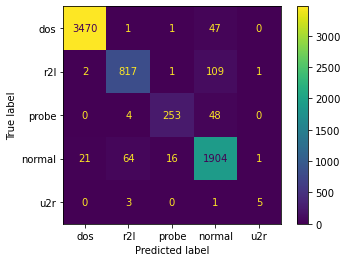

In [20]:
read = open('SVM_Quad_5_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.3 SVM CUBIC</font>

In [21]:
file_exists = os.path.exists('SVM_Cubic_5_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_5_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 162.7979531288147
SVC(C=1000, kernel='poly')
0.956814038688162
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[3479    1    5   34    0]
 [   2  827    1   99    1]
 [   0    5  265   35    0]
 [  20   46   12 1927    1]
 [   0    3    0    1    5]]

% of Correctly classified instances:  0.9607
% of Incorrectly classified instances:  0.0393

Accuracy 0.9607
Precision (Weighted): 0.961
Precision (Micro): 0.9607
Precision (Macro): 0.9003
Recall (Weighted) 0.9607
Recall (Micro) 0.9607
Recall (Macro) 0.8526
F1 Score: 0.9606
F1 Score (Micro): 0.9607
F1 Score (Macro): 0.874
Geometric Mean: 0.9512

Train Time(s) 6.7650980949401855
Test Time(s) 0.6474049091339111


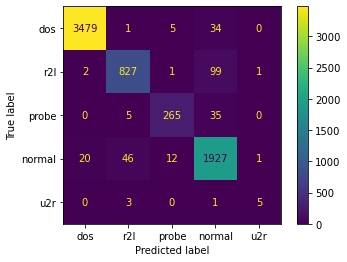

In [22]:
read = open('SVM_Cubic_5_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.4 KNN FINE</font>

In [23]:
file_exists = os.path.exists('KNN_Fine_5_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_5_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 76.15011501312256
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9687817157149613
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3476    4    3   36    0]
 [   3  899    5   21    2]
 [   2    4  286   13    0]
 [  30   63   18 1894    1]
 [   0    2    0    1    6]]

% of Correctly classified instances:  0.9693
% of Incorrectly classified instances:  0.0307

Accuracy 0.9693
Precision (Weighted): 0.9696
Precision (Micro): 0.9693
Precision (Macro): 0.8924
Recall (Weighted) 0.9693
Recall (Micro) 0.9693
Recall (Macro) 0.9006
F1 Score: 0.9693
F1 Score (Micro): 0.9693
F1 Score (Macro): 0.8964
Geometric Mean: 0.9577

Train Time(s) 0.1324610710144043
Test Time(s) 8.80679202079773


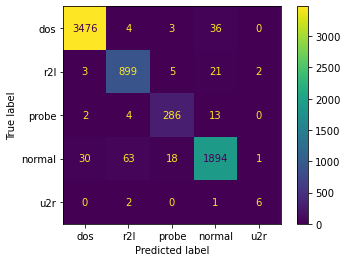

In [24]:
read = open('KNN_Fine_5_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.5 KNN MEDIUM</font>

In [25]:
file_exists = os.path.exists('KNN_Medium_5_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_5_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 65.67050099372864
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9603598255585574
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3479    4    2   34    0]
 [   3  894    4   29    0]
 [   6    4  278   17    0]
 [  41   81   13 1870    1]
 [   0    0    0    2    7]]

% of Correctly classified instances:  0.9644
% of Incorrectly classified instances:  0.0356

Accuracy 0.9644
Precision (Weighted): 0.9647
Precision (Micro): 0.9644
Precision (Macro): 0.9329
Recall (Weighted) 0.9644
Recall (Micro) 0.9644
Recall (Macro) 0.9143
F1 Score: 0.9644
F1 Score (Micro): 0.9644
F1 Score (Macro): 0.9228
Geometric Mean: 0.9507

Train Time(s) 0.13366913795471191
Test Time(s) 10.591563940048218


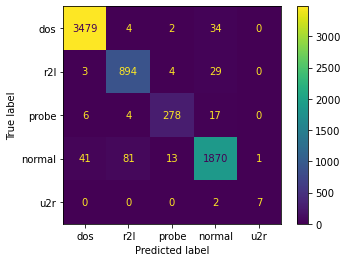

In [26]:
read = open('KNN_Medium_5_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.6 KNN CUBIC</font>

In [27]:
file_exists = os.path.exists('KNN_Cubic_5_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_5_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 618.076103925705
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.959219983806447
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[3477    4    2   36    0]
 [   4  895    4   27    0]
 [   7    4  276   18    0]
 [  46   79   13 1867    1]
 [   0    0    0    2    7]]

% of Correctly classified instances:  0.9635
% of Incorrectly classified instances:  0.0365

Accuracy 0.9635
Precision (Weighted): 0.9638
Precision (Micro): 0.9635
Precision (Macro): 0.9327
Recall (Weighted) 0.9635
Recall (Micro) 0.9635
Recall (Macro) 0.9128
F1 Score: 0.9635
F1 Score (Micro): 0.9635
F1 Score (Macro): 0.9219
Geometric Mean: 0.9487

Train Time(s) 0.41056394577026367
Test Time(s) 92.73811101913452


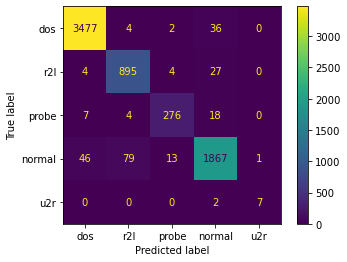

In [28]:
read = open('KNN_Cubic_5_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.7 TREE MEDIUM</font>

In [29]:
file_exists = os.path.exists('Tree_Medium_5_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_5_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 3/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.875 total time=  21.2s
[CV 5/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.883 total time=  18.5s
[CV 10/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.890 total time=  18.1s
[CV 6/10] END C=1, degree=2, gamma=scale, kernel=poly;, score=0.909 total time=  14.1s
[CV 10/10] END C=1, degree=2, gamma=scale, kernel=poly;, score=0.911 total time=  15.6s
[CV 4/10] END C=10, degree=2, gamma=scale, kernel=poly;, score=0.923 total time=  11.5s
[CV 8/10] END C=10, degree=2, gamma=scale, kernel=poly;, score=0.914 total time=  11.0s
[CV 2/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.928 total time=   9.9s
[CV 6/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.946 total time=  10.2s
[CV 10/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.943 total time=   9.8s
[CV 4/10] END C=1000, degree=2, gamma=scale, ker

0

Confusion Matrix Raw Format:
 [[3499    6    4    9    1]
 [   0  888    1   39    2]
 [   3    3  272   27    0]
 [   9   23   17 1947   10]
 [   0    0    0    4    5]]

% of Correctly classified instances:  0.9767
% of Incorrectly classified instances:  0.0233

Accuracy 0.9767
Precision (Weighted): 0.9776
Precision (Micro): 0.9767
Precision (Macro): 0.8252
Recall (Weighted) 0.9767
Recall (Micro) 0.9767
Recall (Macro) 0.8734
F1 Score: 0.977
F1 Score (Micro): 0.9767
F1 Score (Macro): 0.84
Geometric Mean: 0.9732

Train Time(s) 0.03946280479431152
Test Time(s) 0.004955291748046875


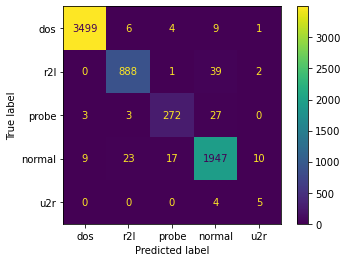

In [30]:
read = open('Tree_Medium_5_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>5.8 TREE FINE</font>

In [31]:
file_exists = os.path.exists('Tree_Fine_5_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_5_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 7/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.948 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.951 total time=   0.1s
[CV 5/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.970 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.969 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.953 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.942 total time=   0.1s
[CV 1/10] END criterion=gini, max

0

Confusion Matrix Raw Format:
 [[3466    1    4   48    0]
 [   0  836   17   70    7]
 [  20    1  242   42    0]
 [  19   36   11 1933    7]
 [   0    0    0    3    6]]

% of Correctly classified instances:  0.9577
% of Incorrectly classified instances:  0.0423

Accuracy 0.9577
Precision (Weighted): 0.959
Precision (Micro): 0.9577
Precision (Macro): 0.8102
Recall (Weighted) 0.9577
Recall (Micro) 0.9577
Recall (Macro) 0.8615
F1 Score: 0.9579
F1 Score (Micro): 0.9577
F1 Score (Macro): 0.8212
Geometric Mean: 0.9471

Train Time(s) 0.04104113578796387
Test Time(s) 0.006121158599853516


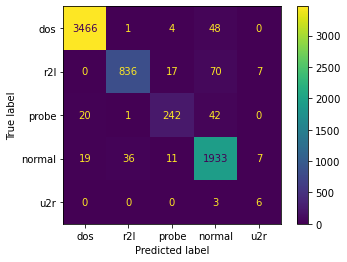

In [32]:
read = open('Tree_Fine_5_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 6</font>
#### Below, 8 algorithms are being fitted on 71 features with 70:30 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with VIF > 10 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [18]:
NSLKDD_DF_RUN6 = NSLKDD_DF.copy()
NSLKDD_DF_RUN6_temp = NSLKDD_DF_RUN6.drop(['attack_category','attack_type'], axis=1)
# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN6.shape)

#Pass dataframe to the VIF method
VIF_col_list = VIF(NSLKDD_DF_RUN6_temp)
# Drop all features returned by VIF
NSLKDD_DF_RUN6.drop(labels=VIF_col_list, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN6.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN6['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN6.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN6, NSLKDD_DF_RUN6_temp

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 73)
(15792, 71) (15792,)
(6769, 71) (6769,)


## <font color='blue'>6.1 SVM LINEAR</font>

In [19]:
file_exists = os.path.exists('SVM_Linear_6_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_6_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 317.03789806365967
SVC(C=1000, kernel='linear')
0.9080548897315237
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Confusion Matrix Raw Format:
 [[ 663    2  261    7    0]
 [   6  238   24   17    0]
 [  72   65 1798   81    2]
 [   1    4   56 3452    0]
 [   6    0    1    3   10]]

% of Correctly classified instances:  0.9102
% of Incorrectly classified instances:  0.0898

Accuracy 0.9102
Precision (Weighted): 0.9108
Precision (Micro): 0.9102
Precision (Macro): 0.86
Recall (Weighted) 0.9102
Recall (Micro) 0.9102
Recall (Macro) 0.7839
F1 Score: 0.9087
F1 Score (Micro): 0.9102
F1 Score (Macro): 0.8112
Geometric Mean: 0.8921

Train Time(s) 26.769572257995605
Test Time(s) 1.2150547504425049


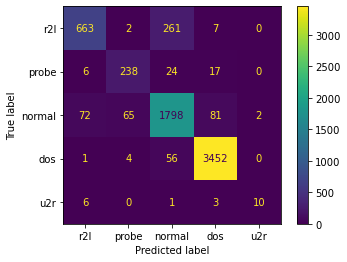

[CV 4/10] END C=0.1, gamma=scale, kernel=linear;, score=0.869 total time=  22.5s
[CV 5/10] END C=0.1, gamma=scale, kernel=linear;, score=0.870 total time=  19.1s
[CV 9/10] END C=0.1, gamma=scale, kernel=linear;, score=0.882 total time=  19.1s
[CV 6/10] END ..C=1, gamma=scale, kernel=linear;, score=0.889 total time=  15.9s
[CV 10/10] END .C=1, gamma=scale, kernel=linear;, score=0.889 total time=  19.1s
[CV 4/10] END .C=10, gamma=scale, kernel=linear;, score=0.898 total time=  16.2s
[CV 8/10] END .C=10, gamma=scale, kernel=linear;, score=0.894 total time=  15.5s
[CV 2/10] END C=100, gamma=scale, kernel=linear;, score=0.892 total time=  18.3s
[CV 5/10] END C=100, gamma=scale, kernel=linear;, score=0.908 total time=  18.2s
[CV 10/10] END C=100, gamma=scale, kernel=linear;, score=0.904 total time=  18.8s
[CV 4/10] END C=1000, gamma=scale, kernel=linear;, score=0.905 total time=  39.8s
[CV 7/10] END C=1000, gamma=scale, kernel=linear;, score=0.914 total time=  42.0s
[CV 3/10] END C=0.1, gamm

In [21]:
read = open('SVM_Linear_6_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.2 SVM QUADRATIC</font>

In [22]:
file_exists = os.path.exists('SVM_Quad_6_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_6_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 189.15799021720886
SVC(C=1000, degree=2, kernel='poly')
0.9508609839587626
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[ 822    2  108    1    0]
 [   2  234   46    3    0]
 [  64   14 1912   25    3]
 [   1    1   58 3453    0]
 [   5    0    9    0    6]]

% of Correctly classified instances:  0.9495
% of Incorrectly classified instances:  0.0505

Accuracy 0.9495
Precision (Weighted): 0.9499
Precision (Micro): 0.9495
Precision (Macro): 0.8813
Recall (Weighted) 0.9495
Recall (Micro) 0.9495
Recall (Macro) 0.7865
F1 Score: 0.949
F1 Score (Micro): 0.9495
F1 Score (Macro): 0.8191
Geometric Mean: 0.9358

Train Time(s) 9.457583904266357
Test Time(s) 0.7636542320251465


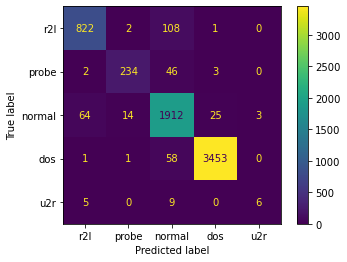

In [23]:
read = open('SVM_Quad_6_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.3 SVM CUBIC</font>

In [24]:
file_exists = os.path.exists('SVM_Cubic_6_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_6_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 158.15146017074585
SVC(C=1000, kernel='poly')
0.9581431526122126
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[ 838    1   93    0    1]
 [   2  248   34    1    0]
 [  50   15 1924   23    6]
 [   1    1   57 3454    0]
 [   5    0    8    1    6]]

% of Correctly classified instances:  0.9558
% of Incorrectly classified instances:  0.0442

Accuracy 0.9558
Precision (Weighted): 0.956
Precision (Micro): 0.9558
Precision (Macro): 0.8469
Recall (Weighted) 0.9558
Recall (Micro) 0.9558
Recall (Macro) 0.801
F1 Score: 0.9556
F1 Score (Micro): 0.9558
F1 Score (Macro): 0.8201
Geometric Mean: 0.9427

Train Time(s) 6.547583103179932
Test Time(s) 0.6525030136108398


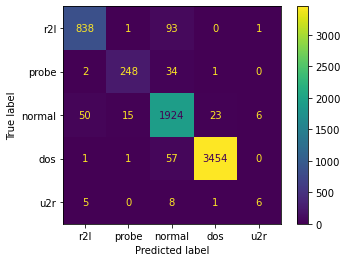

In [25]:
read = open('SVM_Cubic_6_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.4 KNN FINE</font>

In [26]:
file_exists = os.path.exists('KNN_Fine_6_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_6_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 74.6466429233551
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9714413464698856
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 910    3   19    0    1]
 [   4  269    6    6    0]
 [  62   13 1908   31    4]
 [   2    2   19 3490    0]
 [   9    0    4    0    7]]

% of Correctly classified instances:  0.9727
% of Incorrectly classified instances:  0.0273

Accuracy 0.9727
Precision (Weighted): 0.9726
Precision (Micro): 0.9727
Precision (Macro): 0.8815
Recall (Weighted) 0.9727
Recall (Micro) 0.9727
Recall (Macro) 0.8416
F1 Score: 0.9724
F1 Score (Micro): 0.9727
F1 Score (Macro): 0.8555
Geometric Mean: 0.9644

Train Time(s) 0.12838506698608398
Test Time(s) 9.04171109199524


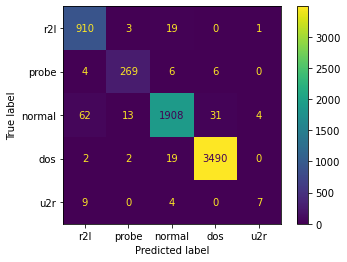

In [27]:
read = open('KNN_Fine_6_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.5 KNN MEDIUM</font>

In [28]:
file_exists = os.path.exists('KNN_Medium_6_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_6_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 67.91511297225952
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9628929542011049
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 902    3   28    0    0]
 [   3  262   11    9    0]
 [  90   13 1873   41    1]
 [   1    2   27 3483    0]
 [   9    1    2    1    7]]

% of Correctly classified instances:  0.9642
% of Incorrectly classified instances:  0.0358

Accuracy 0.9642
Precision (Weighted): 0.9647
Precision (Micro): 0.9642
Precision (Macro): 0.9311
Recall (Weighted) 0.9642
Recall (Micro) 0.9642
Recall (Macro) 0.8311
F1 Score: 0.9639
F1 Score (Micro): 0.9642
F1 Score (Macro): 0.8583
Geometric Mean: 0.9526

Train Time(s) 0.12672114372253418
Test Time(s) 11.844687938690186


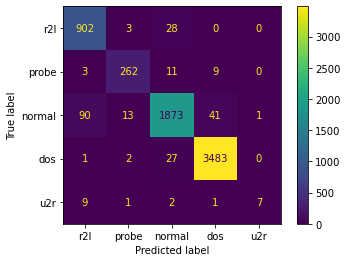

In [29]:
read = open('KNN_Medium_6_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.6 KNN CUBIC</font>

In [30]:
file_exists = os.path.exists('KNN_Cubic_6_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_6_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 537.4503948688507
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.961626409921357
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 900    3   29    1    0]
 [   3  261   12    9    0]
 [  89   13 1875   40    1]
 [   1    2   29 3481    0]
 [   8    1    3    1    7]]

% of Correctly classified instances:  0.9638
% of Incorrectly classified instances:  0.0362

Accuracy 0.9638
Precision (Weighted): 0.9642
Precision (Micro): 0.9638
Precision (Macro): 0.9309
Recall (Weighted) 0.9638
Recall (Micro) 0.9638
Recall (Macro) 0.8301
F1 Score: 0.9634
F1 Score (Micro): 0.9638
F1 Score (Macro): 0.8577
Geometric Mean: 0.9519

Train Time(s) 0.33728575706481934
Test Time(s) 70.23738694190979


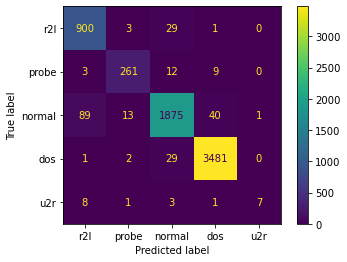

In [31]:
read = open('KNN_Cubic_6_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.7 TREE MEDIUM</font>

In [32]:
file_exists = os.path.exists('Tree_Medium_6_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_6_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 2/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.873 total time=  24.4s
[CV 5/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.883 total time=  18.6s
[CV 9/10] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.890 total time=  17.4s
[CV 5/10] END C=1, degree=2, gamma=scale, kernel=poly;, score=0.902 total time=  12.8s
[CV 9/10] END C=1, degree=2, gamma=scale, kernel=poly;, score=0.903 total time=  12.2s
[CV 3/10] END C=10, degree=2, gamma=scale, kernel=poly;, score=0.934 total time=  10.8s
[CV 7/10] END C=10, degree=2, gamma=scale, kernel=poly;, score=0.934 total time=  11.0s
[CV 2/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.942 total time=   9.8s
[CV 5/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.948 total time=   9.9s
[CV 9/10] END C=100, degree=2, gamma=scale, kernel=poly;, score=0.940 total time=   9.7s
[CV 3/10] END C=1000, degree=2, gamma=scale, kernel

0

Confusion Matrix Raw Format:
 [[ 883    0   49    1    0]
 [   4  263   10    8    0]
 [  38    9 1958   13    0]
 [   1    3   36 3473    0]
 [   5    1    8    0    6]]

% of Correctly classified instances:  0.9725
% of Incorrectly classified instances:  0.0275

Accuracy 0.9725
Precision (Weighted): 0.9727
Precision (Micro): 0.9725
Precision (Macro): 0.969
Recall (Weighted) 0.9725
Recall (Micro) 0.9725
Recall (Macro) 0.8256
F1 Score: 0.972
F1 Score (Micro): 0.9725
F1 Score (Macro): 0.8596
Geometric Mean: 0.9634

Train Time(s) 0.07089996337890625
Test Time(s) 0.009701251983642578


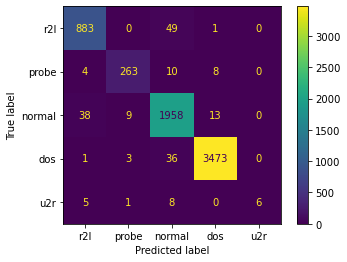

In [33]:
read = open('Tree_Medium_6_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>6.8 TREE FINE</font>

In [34]:
file_exists = os.path.exists('Tree_Fine_6_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_6_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 5/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.973 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.968 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.938 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=20, random_state=42, splitter=random;, score=0.964 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=25, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.963 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=25, max_features=log2, min_samples_split=20, random_state=17, splitter=best;, score=0.949 total time=   0.1s
[CV 9/10] END criterion=gini, max_dep

0

Confusion Matrix Raw Format:
 [[ 848   15   67    1    2]
 [   3  257   20    5    0]
 [  53   14 1929   18    4]
 [   1   12   41 3459    0]
 [   3    1   15    0    1]]

% of Correctly classified instances:  0.9594
% of Incorrectly classified instances:  0.0406

Accuracy 0.9594
Precision (Weighted): 0.9583
Precision (Micro): 0.9594
Precision (Macro): 0.7721
Recall (Weighted) 0.9594
Recall (Micro) 0.9594
Recall (Macro) 0.7602
F1 Score: 0.9587
F1 Score (Micro): 0.9594
F1 Score (Macro): 0.7615
Geometric Mean: 0.9498

Train Time(s) 0.052666664123535156
Test Time(s) 0.005143880844116211


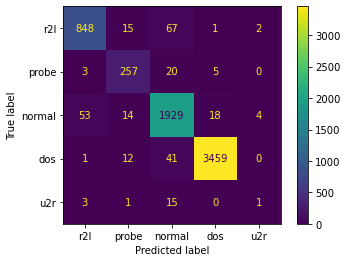

In [35]:
read = open('Tree_Fine_6_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 7</font>
#### Below, 8 algorithms are being fitted on 88 features with 80:20 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with corr > 0.9 and VIF > 10 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [36]:
NSLKDD_DF_RUN7 = NSLKDD_DF.copy()

# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN7.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSLKDD_DF_RUN7)
# Drop all correlated features
NSLKDD_DF_RUN7.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN7.shape)


NSLKDD_DF_RUN7_temp = NSLKDD_DF_RUN7.drop(['attack_category','attack_type'], axis=1)
# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN7.shape)

#Pass dataframe to the VIF method
VIF_col_list = VIF(NSLKDD_DF_RUN7_temp)
# Drop all features returned by VIF
NSLKDD_DF_RUN7.drop(labels=VIF_col_list, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN7.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN7['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN7.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN7, NSLKDD_DF_RUN7_temp

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 106)
Original Shape: (22561, 106)
Modified Shape: (22561, 90)
(18048, 88) (18048,)
(4513, 88) (4513,)


## <font color='blue'>7.1 SVM LINEAR</font>

In [37]:
file_exists = os.path.exists('SVM_Linear_7_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_7_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 335.61208295822144
SVC(C=1000, kernel='linear')
0.9594414382320606
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Confusion Matrix Raw Format:
 [[ 591   20    3    0    0]
 [  39 1307   28   11    2]
 [   1   26 2292    1    0]
 [   4   29    3  148    0]
 [   2    2    1    0    3]]

% of Correctly classified instances:  0.9619
% of Incorrectly classified instances:  0.0381

Accuracy 0.9619
Precision (Weighted): 0.9616
Precision (Micro): 0.9619
Precision (Macro): 0.8764
Recall (Weighted) 0.9619
Recall (Micro) 0.9619
Recall (Macro) 0.8144
F1 Score: 0.9615
F1 Score (Micro): 0.9619
F1 Score (Macro): 0.8393
Geometric Mean: 0.948

Train Time(s) 22.493356943130493
Test Time(s) 0.4201638698577881


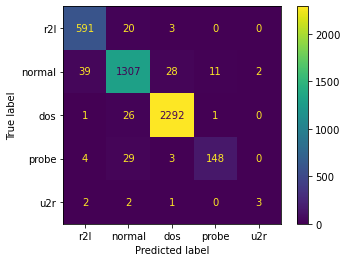

In [38]:
read = open('SVM_Linear_7_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.2 SVM QUADRATIC</font>

In [39]:
file_exists = os.path.exists('SVM_Quad_7_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_7_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 167.54257225990295
SVC(C=1000, degree=2, kernel='poly')
0.9751220126404234
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[ 589   24    1    0    0]
 [  14 1356    6    8    3]
 [   1   14 2305    0    0]
 [   3   24    1  156    0]
 [   1    3    0    0    4]]

% of Correctly classified instances:  0.9772
% of Incorrectly classified instances:  0.0228

Accuracy 0.9772
Precision (Weighted): 0.9772
Precision (Micro): 0.9772
Precision (Macro): 0.8884
Recall (Weighted) 0.9772
Recall (Micro) 0.9772
Recall (Macro) 0.8557
F1 Score: 0.977
F1 Score (Micro): 0.9772
F1 Score (Macro): 0.8709
Geometric Mean: 0.972

Train Time(s) 6.111370086669922
Test Time(s) 0.31422996520996094


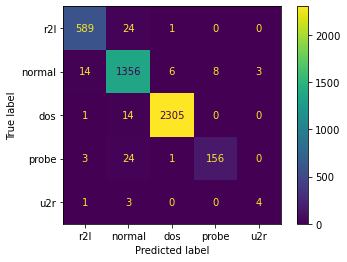

In [40]:
read = open('SVM_Quad_7_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.3 SVM CUBIC</font>

In [41]:
file_exists = os.path.exists('SVM_Cubic_7_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_7_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 152.45914387702942
SVC(C=1000, kernel='poly')
0.9776705812260842
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Confusion Matrix Raw Format:
 [[ 591   22    1    0    0]
 [  12 1359    5    8    3]
 [   1   14 2305    0    0]
 [   2   15    1  166    0]
 [   2    3    0    0    3]]

% of Correctly classified instances:  0.9803
% of Incorrectly classified instances:  0.0197

Accuracy 0.9803
Precision (Weighted): 0.9801
Precision (Micro): 0.9803
Precision (Macro): 0.877
Recall (Weighted) 0.9803
Recall (Micro) 0.9803
Recall (Macro) 0.8426
F1 Score: 0.9801
F1 Score (Micro): 0.9803
F1 Score (Macro): 0.8578
Geometric Mean: 0.9752

Train Time(s) 4.73897385597229
Test Time(s) 0.3021402359008789


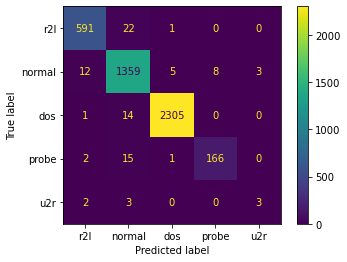

In [42]:
read = open('SVM_Cubic_7_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.4 KNN FINE</font>

In [43]:
file_exists = os.path.exists('KNN_Fine_7_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_7_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 135.3962049484253
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9801635945974165
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 604    8    0    1    1]
 [  18 1347   10    9    3]
 [   1    7 2312    0    0]
 [   3    5    2  174    0]
 [   1    1    0    0    6]]

% of Correctly classified instances:  0.9845
% of Incorrectly classified instances:  0.0155

Accuracy 0.9845
Precision (Weighted): 0.9847
Precision (Micro): 0.9845
Precision (Macro): 0.8977
Recall (Weighted) 0.9845
Recall (Micro) 0.9845
Recall (Macro) 0.9294
F1 Score: 0.9846
F1 Score (Micro): 0.9845
F1 Score (Macro): 0.9119
Geometric Mean: 0.9802

Train Time(s) 0.1700448989868164
Test Time(s) 9.047091960906982


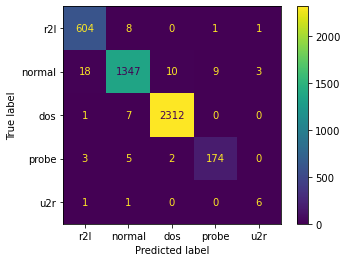

In [44]:
read = open('KNN_Fine_7_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.5 KNN MEDIUM</font>

In [45]:
file_exists = os.path.exists('KNN_Medium_7_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_7_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 114.4448790550232
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9741241685144123
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 606    7    1    0    0]
 [  34 1315   23   13    2]
 [   3    9 2307    1    0]
 [   2    7    4  171    0]
 [   2    2    0    0    4]]

% of Correctly classified instances:  0.9756
% of Incorrectly classified instances:  0.0244

Accuracy 0.9756
Precision (Weighted): 0.9758
Precision (Micro): 0.9756
Precision (Macro): 0.8994
Recall (Weighted) 0.9756
Recall (Micro) 0.9756
Recall (Macro) 0.8718
F1 Score: 0.9755
F1 Score (Micro): 0.9756
F1 Score (Macro): 0.883
Geometric Mean: 0.9664

Train Time(s) 0.1893749237060547
Test Time(s) 11.861461877822876


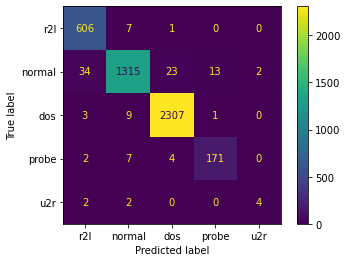

In [46]:
read = open('KNN_Medium_7_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.6 KNN CUBIC</font>

In [47]:
file_exists = os.path.exists('KNN_Cubic_7_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_7_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 835.245395898819
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.9730161659838709
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Confusion Matrix Raw Format:
 [[ 603    8    3    0    0]
 [  30 1315   27   13    2]
 [   3    9 2307    1    0]
 [   2    9    5  168    0]
 [   3    1    0    0    4]]

% of Correctly classified instances:  0.9743
% of Incorrectly classified instances:  0.0257

Accuracy 0.9743
Precision (Weighted): 0.9743
Precision (Micro): 0.9743
Precision (Macro): 0.8991
Recall (Weighted) 0.9743
Recall (Micro) 0.9743
Recall (Macro) 0.8675
F1 Score: 0.9741
F1 Score (Micro): 0.9743
F1 Score (Macro): 0.8808
Geometric Mean: 0.964

Train Time(s) 0.4684422016143799
Test Time(s) 65.1268880367279


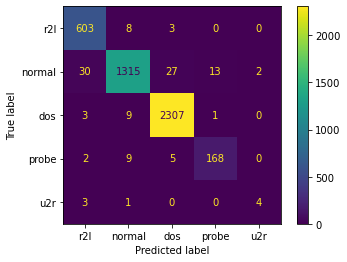

In [48]:
read = open('KNN_Cubic_7_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.7 TREE MEDIUM</font>

In [49]:
file_exists = os.path.exists('Tree_Medium_7_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_7_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 3/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.927 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=17, splitter=random;, score=0.925 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.958 total time=   0.2s
[CV 2/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.946 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.948 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=100, random_state=42, splitter=best;, score=0.966 total time=   0.1s
[CV 7/10] END criterion=gini, 

0

Confusion Matrix Raw Format:
 [[ 591   20    1    1    1]
 [  15 1340   10   19    3]
 [   0   10 2307    3    0]
 [   1    9    4  170    0]
 [   1    2    0    0    5]]

% of Correctly classified instances:  0.9778
% of Incorrectly classified instances:  0.0222

Accuracy 0.9778
Precision (Weighted): 0.9781
Precision (Micro): 0.9778
Precision (Macro): 0.8745
Recall (Weighted) 0.9778
Recall (Micro) 0.9778
Recall (Macro) 0.8944
F1 Score: 0.9779
F1 Score (Micro): 0.9778
F1 Score (Macro): 0.8839
Geometric Mean: 0.9722

Train Time(s) 0.0798332691192627
Test Time(s) 0.004902839660644531


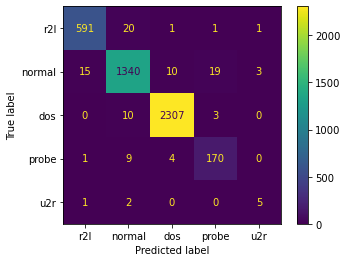

In [50]:
read = open('Tree_Medium_7_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>7.8 TREE FINE</font>

In [51]:
file_exists = os.path.exists('Tree_Fine_7_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_7_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 5/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.742 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=best;, score=0.756 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.776 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=17, splitter=random;, score=0.749 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.748 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=20, random_state=42, splitter=best;, score=0.760 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=5, 

0

Confusion Matrix Raw Format:
 [[ 548   63    1    2    0]
 [  41 1325    6   15    0]
 [   1   39 2273    4    3]
 [  10   26    5  143    0]
 [   2    4    0    0    2]]

% of Correctly classified instances:  0.9508
% of Incorrectly classified instances:  0.0492

Accuracy 0.9508
Precision (Weighted): 0.951
Precision (Micro): 0.9508
Precision (Macro): 0.8173
Recall (Weighted) 0.9508
Recall (Micro) 0.9508
Recall (Macro) 0.7709
F1 Score: 0.9505
F1 Score (Micro): 0.9508
F1 Score (Macro): 0.79
Geometric Mean: 0.9386

Train Time(s) 0.059084177017211914
Test Time(s) 0.007241249084472656


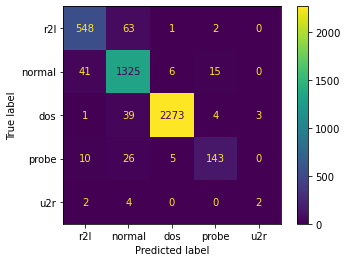

[CV 6/10] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=100, random_state=42, splitter=random;, score=0.755 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.757 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state=17, splitter=best;, score=0.763 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.598 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.599 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state=17, splitter=random;, score=0.669 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, random_state

In [52]:
read = open('Tree_Fine_7_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color=green>RUN 8</font>
#### Below, 8 algorithms are being fitted on 88 features with 70:30 split. Protocol_Type, Flag and Service have been one-hot encloded. Feature(s) with corr > 0.9 and VIF > 10 are dropped
1. SVM LINEAR, 2. SVM QUADRATIC, 3. SVM CUBIC, 4. KNN FINE, 5. KNN MEDIUM, 6. KNN CUBIC, 7. TREE MEDIUM, 8. TREE FINE

In [19]:
NSLKDD_DF_RUN8 = NSLKDD_DF.copy()

# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN8.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSLKDD_DF_RUN8)
# Drop all correlated features
NSLKDD_DF_RUN8.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN8.shape)


NSLKDD_DF_RUN8_temp = NSLKDD_DF_RUN8.drop(['attack_category','attack_type'], axis=1)
# No. of features before drop
print("Original Shape:",NSLKDD_DF_RUN8.shape)

#Pass dataframe to the VIF method
VIF_col_list = VIF(NSLKDD_DF_RUN8_temp)
# Drop all features returned by VIF
NSLKDD_DF_RUN8.drop(labels=VIF_col_list, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSLKDD_DF_RUN8.shape)

NSLKDD_DF_Y = NSLKDD_DF_RUN8['attack_category']
NSLKDD_DF_X_raw = NSLKDD_DF_RUN8.drop(['attack_category','attack_type'], axis=1)

del NSLKDD_DF_RUN8, NSLKDD_DF_RUN8_temp

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique()

Original Shape: (22561, 115)
Modified Shape: (22561, 106)
Original Shape: (22561, 106)
Modified Shape: (22561, 90)
(15792, 88) (15792,)
(6769, 88) (6769,)


## <font color='blue'>8.1 SVM LINEAR</font>

In [54]:
file_exists = os.path.exists('SVM_Linear_8_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Linear_8_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 236.0760259628296
SVC(C=1000, kernel='linear')
0.9583332665282466
{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


0

Best Parameters Saved: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}
Confusion Matrix Raw Format:
 [[3444   25    4    4    0]
 [  50 1913   43   13    4]
 [  12   36  884    3    1]
 [   8   42    8  260    0]
 [   1    3    5    0    6]]

% of Correctly classified instances:  0.9613
% of Incorrectly classified instances:  0.0387

Accuracy 0.9613
Precision (Weighted): 0.9608
Precision (Micro): 0.9613
Precision (Macro): 0.8676
Recall (Weighted) 0.9613
Recall (Micro) 0.9613
Recall (Macro) 0.8196
F1 Score: 0.9608
F1 Score (Micro): 0.9613
F1 Score (Macro): 0.8406
Geometric Mean: 0.9478

Train Time(s) 37.53820180892944
Test Time(s) 1.02144193649292


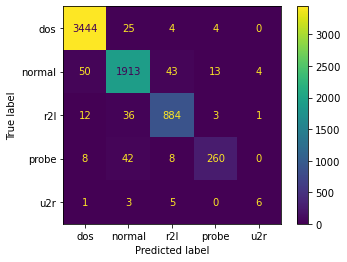

In [20]:
read = open('SVM_Linear_8_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
gamma = best[1]
kernel = best[2]

start_train = time.time()
clf = SVC(C = C, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.2 SVM QUADRATIC</font>

In [56]:
file_exists = os.path.exists('SVM_Quad_8_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Quad_8_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 122.16060209274292
SVC(C=1000, degree=2, kernel='poly')
0.9751768063427422
{'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


0

Best Parameters Saved: {'C': 1000, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Confusion Matrix Raw Format:
 [[3446   27    4    0    0]
 [  11 1977   20   11    4]
 [   1   47  887    0    1]
 [   0   37    2  279    0]
 [   0    5    5    0    5]]

% of Correctly classified instances:  0.9741
% of Incorrectly classified instances:  0.0259

Accuracy 0.9741
Precision (Weighted): 0.9741
Precision (Micro): 0.9741
Precision (Macro): 0.8739
Recall (Weighted) 0.9741
Recall (Micro) 0.9741
Recall (Macro) 0.8253
F1 Score: 0.9739
F1 Score (Micro): 0.9741
F1 Score (Macro): 0.8458
Geometric Mean: 0.9675

Train Time(s) 8.287353992462158
Test Time(s) 0.6259710788726807


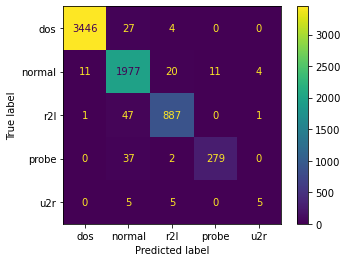

In [21]:
read = open('SVM_Quad_8_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.3 SVM CUBIC</font>

In [58]:
file_exists = os.path.exists('SVM_Cubic_8_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters3,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('SVM_Cubic_8_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
total time 113.42362380027771
SVC(C=1000, kernel='poly')
0.9780900024851492
{'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


0

Best Parameters Saved: {'C': 1000, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Confusion Matrix Raw Format:
 [[3458   15    4    0    0]
 [  13 1975   22    9    4]
 [   3   33  899    0    1]
 [   0   28    2  288    0]
 [   1    4    5    0    5]]

% of Correctly classified instances:  0.9787
% of Incorrectly classified instances:  0.0213

Accuracy 0.9787
Precision (Weighted): 0.9784
Precision (Micro): 0.9787
Precision (Macro): 0.8781
Recall (Weighted) 0.9787
Recall (Micro) 0.9787
Recall (Macro) 0.8341
F1 Score: 0.9785
F1 Score (Micro): 0.9787
F1 Score (Macro): 0.8525
Geometric Mean: 0.9735

Train Time(s) 6.212260961532593
Test Time(s) 0.48027992248535156


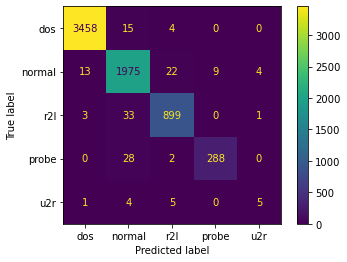

In [22]:
read = open('SVM_Cubic_8_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
C = best[0]
degree = best[1]
gamma = best[2]
kernel = best[3]

start_train = time.time()
clf = SVC(C = C, degree = degree, gamma = gamma, kernel = kernel)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.4 KNN FINE</font>

In [60]:
file_exists = os.path.exists('KNN_Fine_8_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters4,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Fine_8_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 89.75704216957092
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=1, p=1,
                     weights='distance')
0.9814464771005523
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


0

Best Parameters Saved: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Confusion Matrix Raw Format:
 [[3463   11    1    2    0]
 [  16 1965   27    9    6]
 [   3   19  914    0    0]
 [   7    6    6  299    0]
 [   1    4    3    0    7]]

% of Correctly classified instances:  0.9821
% of Incorrectly classified instances:  0.0179

Accuracy 0.9821
Precision (Weighted): 0.982
Precision (Micro): 0.9821
Precision (Macro): 0.8873
Recall (Weighted) 0.9821
Recall (Micro) 0.9821
Recall (Macro) 0.8701
F1 Score: 0.982
F1 Score (Micro): 0.9821
F1 Score (Macro): 0.8781
Geometric Mean: 0.9767

Train Time(s) 0.2284679412841797
Test Time(s) 21.43166995048523


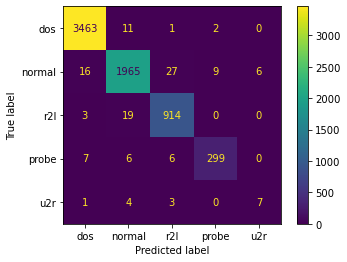

In [23]:
read = open('KNN_Fine_8_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.5 KNN MEDIUM</font>

In [62]:
file_exists = os.path.exists('KNN_Medium_8_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters5,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Medium_8_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 75.45310115814209
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10,
                     weights='distance')
0.9742275995863429
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


0

Best Parameters Saved: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Confusion Matrix Raw Format:
 [[3457   12    7    1    0]
 [  34 1943   30   13    3]
 [   5   27  903    0    1]
 [  10   11    6  291    0]
 [   1    4    3    0    7]]

% of Correctly classified instances:  0.9752
% of Incorrectly classified instances:  0.0248

Accuracy 0.9752
Precision (Weighted): 0.9749
Precision (Micro): 0.9752
Precision (Macro): 0.9001
Recall (Weighted) 0.9752
Recall (Micro) 0.9752
Recall (Macro) 0.8602
F1 Score: 0.975
F1 Score (Micro): 0.9752
F1 Score (Macro): 0.8775
Geometric Mean: 0.9657

Train Time(s) 0.3048582077026367
Test Time(s) 31.148273944854736


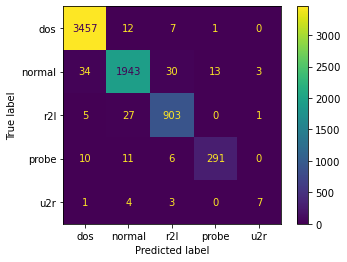

In [24]:
read = open('KNN_Medium_8_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.6 KNN CUBIC</font>

In [64]:
file_exists = os.path.exists('KNN_Cubic_8_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters6,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('KNN_Cubic_8_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
total time 627.0460350513458
KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=10, p=3,
                     weights='distance')
0.9732777515011103
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}


0

Best Parameters Saved: {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 3, 'weights': 'distance'}
Confusion Matrix Raw Format:
 [[3456   13    7    1    0]
 [  36 1935   36   13    3]
 [   8   25  902    0    1]
 [  12   12    5  289    0]
 [   1    4    3    0    7]]

% of Correctly classified instances:  0.9734
% of Incorrectly classified instances:  0.0266

Accuracy 0.9734
Precision (Weighted): 0.9732
Precision (Micro): 0.9734
Precision (Macro): 0.8987
Recall (Weighted) 0.9734
Recall (Micro) 0.9734
Recall (Macro) 0.8579
F1 Score: 0.9732
F1 Score (Micro): 0.9734
F1 Score (Macro): 0.8755
Geometric Mean: 0.9629

Train Time(s) 1.448988914489746
Test Time(s) 181.57645201683044


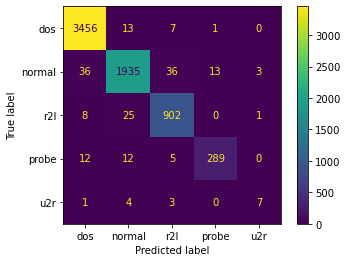

In [25]:
read = open('KNN_Cubic_8_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
algorithm = best[0]
leaf_size = best[1]
metric = best[2]
n_neighbors = best[3]
p = best[4]
weights = best[5]

start_train = time.time()
clf = KNeighborsClassifier(algorithm = algorithm, leaf_size = leaf_size, metric = metric, n_neighbors = n_neighbors, \
                           p = p, weights = weights)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.7 TREE MEDIUM</font>

In [66]:
file_exists = os.path.exists('Tree_Medium_8_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters7,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Medium_8_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
total time 33.63123917579651
DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       min_samples_split=20, random_state=42)
0.9715678886653146
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}


0

Best Parameters Saved: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 20, 'random_state': 42, 'splitter': 'best'}
Confusion Matrix Raw Format:
 [[3446   21    0   10    0]
 [  24 1950   36   12    1]
 [   4   47  879    2    4]
 [   3   17    8  290    0]
 [   2    7    3    0    3]]

% of Correctly classified instances:  0.9703
% of Incorrectly classified instances:  0.0297

Accuracy 0.9703
Precision (Weighted): 0.9697
Precision (Micro): 0.9703
Precision (Macro): 0.8387
Recall (Weighted) 0.9703
Recall (Micro) 0.9703
Recall (Macro) 0.8012
F1 Score: 0.9699
F1 Score (Micro): 0.9703
F1 Score (Macro): 0.8146
Geometric Mean: 0.9619

Train Time(s) 0.07085633277893066
Test Time(s) 0.012609004974365234


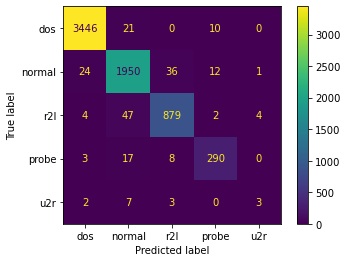

In [26]:
read = open('Tree_Medium_8_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

## <font color='blue'>8.8 TREE FINE</font>

In [68]:
file_exists = os.path.exists('Tree_Fine_8_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    dt = DecisionTreeClassifier()
    clf = GridSearchCV(dt, parameters8,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    os.system('say "Grid Search complete."')
    with open('Tree_Fine_8_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[CV 4/10] END C=0.1, gamma=scale, kernel=linear;, score=0.936 total time=  20.5s
[CV 8/10] END C=0.1, gamma=scale, kernel=linear;, score=0.923 total time=  15.9s
[CV 2/10] END ..C=1, gamma=scale, kernel=linear;, score=0.947 total time=  12.0s
[CV 4/10] END ..C=1, gamma=scale, kernel=linear;, score=0.946 total time=  12.0s
[CV 8/10] END ..C=1, gamma=scale, kernel=linear;, score=0.940 total time=  11.9s
[CV 2/10] END .C=10, gamma=scale, kernel=linear;, score=0.951 total time=  13.9s
[CV 6/10] END .C=10, gamma=scale, kernel=linear;, score=0.944 total time=  12.7s
[CV 10/10] END C=10, gamma=scale, kernel=linear;, score=0.942 total time=  10.5s
[CV 4/10] END C=100, gamma=scale, kernel=linear;, score=0.963 total time=  14.5s
[CV 8/10] END C=100, gamma=scale, kernel=linear;, score=0.957 total time=  14.0s
[CV 2/10] END C=1000, gamma=scale, kernel=linear;, score=0.961 total time=  27.1s
[CV 5/10] END C=1000, gamma=scale, kernel=l

0

Best Parameters Saved: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 100, 'random_state': 42, 'splitter': 'best'}
Confusion Matrix Raw Format:
 [[3431   31    2   13    0]
 [  24 1911   51   37    0]
 [   0   63  857   15    1]
 [  10   22    3  283    0]
 [   0    5    3    1    6]]

% of Correctly classified instances:  0.9585
% of Incorrectly classified instances:  0.0415

Accuracy 0.9585
Precision (Weighted): 0.9591
Precision (Micro): 0.9585
Precision (Macro): 0.9069
Recall (Weighted) 0.9585
Recall (Micro) 0.9585
Recall (Macro) 0.8274
F1 Score: 0.9585
F1 Score (Micro): 0.9585
F1 Score (Macro): 0.8501
Geometric Mean: 0.9487

Train Time(s) 0.15081214904785156
Test Time(s) 0.008543014526367188


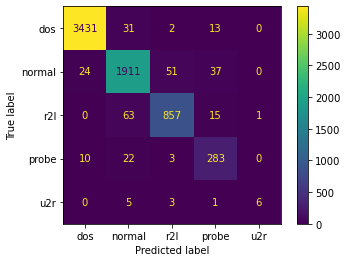

In [27]:
read = open('Tree_Fine_8_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()
    
criterion = best[0]
max_depth = best[1]
max_features = best[2]
min_samples_split = best[3]
random_state = best[4]
splitter = best[5]

start_train = time.time()
clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, \
                             min_samples_split = min_samples_split, random_state = random_state, splitter = splitter)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test
  
values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

# Q2.

In [56]:
# searching for the best parameters
mlp_parameters1 = {
    'activation':['relu','tanh','logistic','identity'],
    'learning_rate':['constant','invscaling','adaptive'],
    'max_iter':[400],
    'solver': ['adam'],
    'random_state':[0],
    'warm_start':[True]
}

### Experiment 1: MLP Classifier w/o in any feature removal, default hidden layer, and 80:20 split ratio

In [57]:
NSKKDD_NewML_DF = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF['attack_category'] = NSKKDD_NewML_DF['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


In [58]:
NSLKDD_DF_Y = NSKKDD_NewML_DF['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF.drop(['attack_category'], axis=1)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF

(18048, 113) (18048,)
(4513, 113) (4513,)


In [161]:
file_exists = os.path.exists('Experiment_1.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_1.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warning

total time 3504.926959991455
MLPClassifier(max_iter=400, random_state=0, warm_start=True)
0.9880875063724195
{'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1341    4    3   23    1]
 [   2 2317    2    0    0]
 [   0    0  185    0    0]
 [  13    0    0  613    0]
 [   2    0    0    0    7]]

% of Correctly classified instances:  0.9889
% of Incorrectly classified instances:  0.0111

Accuracy 0.9889
Precision (Weighted): 0.989
Precision (Micro): 0.9889
Precision (Macro): 0.9597
Recall (Weighted) 0.9889
Recall (Micro) 0.9889
Recall (Macro) 0.9465
F1 Score: 0.9889
F1 Score (Micro): 0.9889
F1 Score (Macro): 0.9525
Geometric Mean: 0.9862

Train Time(s) 55.27316999435425
Test Time(s) 0.021400928497314453


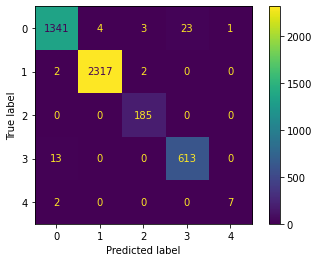

In [59]:
read = open('Experiment_1.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
learning_rate = best[1]
max_iter = best[2]
random_state = best[3]
solver = best[4]
warm_start = best[5]

start_train = time.time()
clf = MLPClassifier(activation = activation, learning_rate = learning_rate, max_iter = max_iter, random_state = random_state, \
                    solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 2: MLP Classifier with feature elimination using just correlation, default hidden layer, and 80:20 split ratio

In [60]:
NSKKDD_NewML_DF1 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF1['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF1['attack_category'] = NSKKDD_NewML_DF1['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF1.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF1.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


### Correlation between features

In [61]:
# No. of features before drop
print("Original Shape:",NSKKDD_NewML_DF1.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSKKDD_NewML_DF1)
# Drop all correlated features
NSKKDD_NewML_DF1.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSKKDD_NewML_DF1.shape)

Original Shape: (22561, 114)
Modified Shape: (22561, 105)


In [62]:
NSLKDD_DF_Y = NSKKDD_NewML_DF1['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF1.drop(['attack_category'], axis=1)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF1

(18048, 104) (18048,)
(4513, 104) (4513,)


In [172]:
file_exists = os.path.exists('Experiment_2.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_2.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warning

total time 3251.548321723938
MLPClassifier(max_iter=400, random_state=0, warm_start=True)
0.9872007726750651
{'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1367    6    4   20    0]
 [   1 2309    0    0    0]
 [   3    1  192    0    0]
 [  21    0    0  580    0]
 [   1    0    0    2    6]]

% of Correctly classified instances:  0.9869
% of Incorrectly classified instances:  0.0131

Accuracy 0.9869
Precision (Weighted): 0.9869
Precision (Micro): 0.9869
Precision (Macro): 0.9843
Recall (Weighted) 0.9869
Recall (Micro) 0.9869
Recall (Macro) 0.9179
F1 Score: 0.9869
F1 Score (Micro): 0.9869
F1 Score (Macro): 0.9444
Geometric Mean: 0.9842

Train Time(s) 61.790841817855835
Test Time(s) 0.015365123748779297


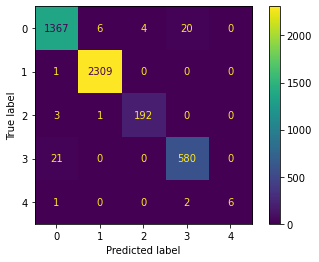

In [63]:
read = open('Experiment_2.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
learning_rate = best[1]
max_iter = best[2]
random_state = best[3]
solver = best[4]
warm_start = best[5]


start_train = time.time()
clf = MLPClassifier(activation = activation, learning_rate = learning_rate, max_iter = max_iter, random_state = random_state, \
                    solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 3: MLP Classifier with feature elimination using p-value, default hidden layer, and 80:20 split ratio

In [64]:
NSKKDD_NewML_DF2 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF2['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF2['attack_category'] = NSKKDD_NewML_DF2['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF2.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF2.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


## p-Value

In [65]:
result = pd.DataFrame()
result['attack_category'] = NSKKDD_NewML_DF2['attack_category']
NSLKDD_DF_Y = NSKKDD_NewML_DF2['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF2.drop(['attack_category'], axis=1,inplace=True)
selected_columns = NSKKDD_NewML_DF2.columns
selected_columns.shape

SL = 0.05
data_modeled, selected_columns = backwardElimination(NSKKDD_NewML_DF2.values, NSLKDD_DF_Y.values, SL, selected_columns)
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(data, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF2

(18048, 98) (18048,)
(4513, 98) (4513,)


In [176]:
file_exists = os.path.exists('Experiment_3.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_3.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warning

total time 3216.6991879940033
MLPClassifier(max_iter=400, random_state=0, warm_start=True)
0.9887519577915496
{'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1397    1    2   14    0]
 [   0 2283    1    0    0]
 [   4    2  197    1    0]
 [   5    0    1  594    1]
 [   4    0    0    1    5]]

% of Correctly classified instances:  0.9918
% of Incorrectly classified instances:  0.0082

Accuracy 0.9918
Precision (Weighted): 0.9917
Precision (Micro): 0.9918
Precision (Macro): 0.9553
Recall (Weighted) 0.9918
Recall (Micro) 0.9918
Recall (Macro) 0.8883
F1 Score: 0.9916
F1 Score (Micro): 0.9918
F1 Score (Macro): 0.9135
Geometric Mean: 0.9912

Train Time(s) 42.69938015937805
Test Time(s) 0.010367870330810547


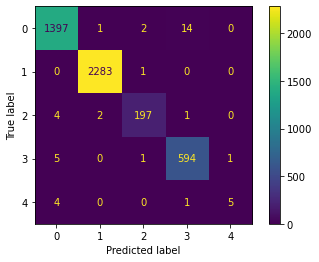

In [66]:
read = open('Experiment_3.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
learning_rate = best[1]
max_iter = best[2]
random_state = best[3]
solver = best[4]
warm_start = best[5]


start_train = time.time()
clf = MLPClassifier(activation = activation, learning_rate = learning_rate, max_iter = max_iter, random_state = random_state, \
                    solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 4: MLP Classifier with feature elimination using correlation and p-value, default hidden layer, and 80:20 split ratio

In [67]:
NSKKDD_NewML_DF3 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF3['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF3['attack_category'] = NSKKDD_NewML_DF3['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF3.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF3.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


### Correlation between features

In [68]:
# No. of features before drop
print("Original Shape:",NSKKDD_NewML_DF3.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSKKDD_NewML_DF3)
# Drop all correlated features
NSKKDD_NewML_DF3.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSKKDD_NewML_DF3.shape)

Original Shape: (22561, 114)
Modified Shape: (22561, 105)


### p-Value

In [69]:
result = pd.DataFrame()
result['attack_category'] = NSKKDD_NewML_DF3['attack_category']
NSLKDD_DF_Y = NSKKDD_NewML_DF3['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF3.drop(['attack_category'], axis=1,inplace=True)
selected_columns = NSKKDD_NewML_DF3.columns
selected_columns.shape

SL = 0.05
data_modeled, selected_columns = backwardElimination(NSKKDD_NewML_DF3.values, NSLKDD_DF_Y.values, SL, selected_columns)
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(data, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF3

(18048, 41) (18048,)
(4513, 41) (4513,)


In [181]:
file_exists = os.path.exists('Experiment_4.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters1,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_4.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dushyantsapre/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warning

total time 2357.8612179756165
MLPClassifier(max_iter=400, random_state=0, warm_start=True)
0.9863699012965954
{'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 0, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1341    5    1   19    0]
 [   0 2332    2    0    0]
 [   2    2  193    0    0]
 [  18    0    0  589    1]
 [   1    0    0    2    5]]

% of Correctly classified instances:  0.9883
% of Incorrectly classified instances:  0.0117

Accuracy 0.9883
Precision (Weighted): 0.9882
Precision (Micro): 0.9883
Precision (Macro): 0.953
Recall (Weighted) 0.9883
Recall (Micro) 0.9883
Recall (Macro) 0.9109
F1 Score: 0.9882
F1 Score (Micro): 0.9883
F1 Score (Macro): 0.929
Geometric Mean: 0.986

Train Time(s) 35.19926071166992
Test Time(s) 0.009908199310302734


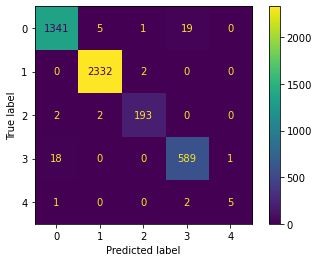

In [70]:
read = open('Experiment_4.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
learning_rate = best[1]
max_iter = best[2]
random_state = best[3]
solver = best[4]
warm_start = best[5]


start_train = time.time()
clf = MLPClassifier(activation = activation, learning_rate = learning_rate, max_iter = max_iter, random_state = random_state, \
                    solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

In [71]:
# searching for the best parameters for MLP

mlp_parameters2 = {
    'activation':['relu'],
    'alpha': [0.0001, 0.05],
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'learning_rate':['constant','invscaling','adaptive'],
    'max_iter':[400],
    'solver': ['adam'],
    'warm_start':[True]
}

### Experiment 5: MLP Classifier with no feature elimination, default solver, default activation,  and 70:30 split ratio

In [72]:
NSKKDD_NewML_DF4 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF4['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF4['attack_category'] = NSKKDD_NewML_DF4['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF4.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF4.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


In [73]:
NSLKDD_DF_Y = NSKKDD_NewML_DF4['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF4.drop(['attack_category'], axis=1)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF4

(15792, 113) (15792,)
(6769, 113) (6769,)


In [21]:
file_exists = os.path.exists('Experiment_5.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_5.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
total time 2567.699802160263
MLPClassifier(hidden_layer_sizes=(120, 80, 40), learning_rate='invscaling',
              max_iter=400, warm_start=True)
0.9891722849744673
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'invscaling', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [120, 80, 40], 'learning_rate': 'invscaling', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1976    8    4   31    1]
 [   2 3489    1    0    0]
 [   7    0  291    0    0]
 [  16    0    2  922    1]
 [   2    1    0    4   11]]

% of Correctly classified instances:  0.9882
% of Incorrectly classified instances:  0.0118

Accuracy 0.9882
Precision (Weighted): 0.9881
Precision (Micro): 0.9882
Precision (Macro): 0.954
Recall (Weighted) 0.9882
Recall (Micro) 0.9882
Recall (Macro) 0.909
F1 Score: 0.9881
F1 Score (Micro): 0.9882
F1 Score (Macro): 0.9277
Geometric Mean: 0.9863

Train Time(s) 34.741026163101196
Test Time(s) 0.05186295509338379


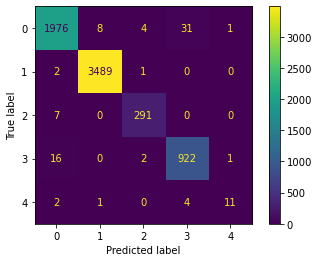

In [74]:
read = open('Experiment_5.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
alpha = best[1]
hidden_layer_sizes = best[2]
learning_rate = best[3]
max_iter = best[4]
solver = best[5]
warm_start = best[6]

start_train = time.time()
clf = MLPClassifier(activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, \
                    learning_rate = learning_rate, max_iter = max_iter, solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 6: MLP Classifier with feature elimination using just correlation, default solver, default activation,  and 70:30 split ratio

In [75]:
NSKKDD_NewML_DF5 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF5['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF5['attack_category'] = NSKKDD_NewML_DF5['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF5.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF5.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


### Correlation between features

In [76]:
# No. of features before drop
print("Original Shape:",NSKKDD_NewML_DF5.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSKKDD_NewML_DF5)
# Drop all correlated features
NSKKDD_NewML_DF5.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSKKDD_NewML_DF5.shape)

Original Shape: (22561, 114)
Modified Shape: (22561, 105)


In [77]:
NSLKDD_DF_Y = NSKKDD_NewML_DF5['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF5.drop(['attack_category'], axis=1)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(NSLKDD_DF_X_raw, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF5

(15792, 104) (15792,)
(6769, 104) (6769,)


In [26]:
file_exists = os.path.exists('Experiment_6.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)

    os.system('say "Grid Search complete."')

    with open('Experiment_6.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
total time 2642.676463842392
MLPClassifier(hidden_layer_sizes=(150, 100, 50), learning_rate='invscaling',
              max_iter=400, warm_start=True)
0.9883485782541426
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'invscaling', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}


Best Parameters Saved: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [150, 100, 50], 'learning_rate': 'invscaling', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1967    8    8   42    1]
 [   1 3529    1    0    0]
 [   0    0  274    3    0]
 [  15    0    2  901    2]
 [   2    0    0    5    8]]

% of Correctly classified instances:  0.9867
% of Incorrectly classified instances:  0.0133

Accuracy 0.9867
Precision (Weighted): 0.9868
Precision (Micro): 0.9867
Precision (Macro): 0.925
Recall (Weighted) 0.9867
Recall (Micro) 0.9867
Recall (Macro) 0.8944
F1 Score: 0.9866
F1 Score (Micro): 0.9867
F1 Score (Macro): 0.9066
Geometric Mean: 0.9854

Train Time(s) 45.537368059158325
Test Time(s) 0.037818193435668945


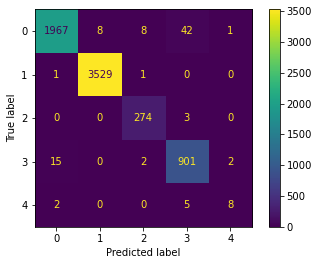

In [78]:
read = open('Experiment_6.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
alpha = best[1]
hidden_layer_sizes = best[2]
learning_rate = best[3]
max_iter = best[4]
solver = best[5]
warm_start = best[6]

start_train = time.time()
clf = MLPClassifier(activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, \
                    learning_rate = learning_rate, max_iter = max_iter, solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 7: MLP Classifier with feature elimination using just p-value, default solver, default activation,  and 70:30 split ratio

In [79]:
NSKKDD_NewML_DF6 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF6['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF6['attack_category'] = NSKKDD_NewML_DF6['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF6.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF6.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


### p-value

In [80]:
result = pd.DataFrame()
result['attack_category'] = NSKKDD_NewML_DF6['attack_category']
NSLKDD_DF_Y = NSKKDD_NewML_DF6['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF6.drop(['attack_category'], axis=1,inplace=True)
selected_columns = NSKKDD_NewML_DF6.columns
selected_columns.shape

SL = 0.05
data_modeled, selected_columns = backwardElimination(NSKKDD_NewML_DF6.values, NSLKDD_DF_Y.values, SL, selected_columns)
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(data, NSLKDD_DF_Y, test_size = 0.20)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF6

(18048, 98) (18048,)
(4513, 98) (4513,)


In [30]:
file_exists = os.path.exists('Experiment_7.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
    
    os.system('say "Grid Search complete."')

    with open('Experiment_7.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 3/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.987 total time= 1.0min
[CV 5/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.990 total time= 1.3min
[CV 1/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.978 total time= 1.0min
[CV 4/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.987 total time=  52.9s
[CV 8/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.989 total time= 1.2min
[CV 2/10] END activation=relu, 

Best Parameters Saved: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [150, 100, 50], 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[1290    7    3   17    1]
 [   1 2351    0    0    0]
 [   1    1  199    0    0]
 [   5    0    0  622    2]
 [   1    0    0    2   10]]

% of Correctly classified instances:  0.9909
% of Incorrectly classified instances:  0.0091

Accuracy 0.9909
Precision (Weighted): 0.991
Precision (Micro): 0.9909
Precision (Macro): 0.943
Recall (Weighted) 0.9909
Recall (Micro) 0.9909
Recall (Macro) 0.9453
F1 Score: 0.9909
F1 Score (Micro): 0.9909
F1 Score (Macro): 0.9441
Geometric Mean: 0.9889

Train Time(s) 84.98700094223022
Test Time(s) 0.02955913543701172


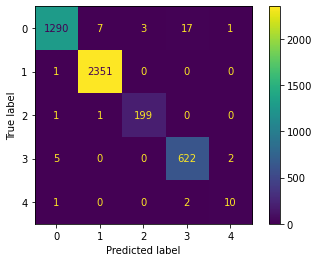

In [81]:
read = open('Experiment_7.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
alpha = best[1]
hidden_layer_sizes = best[2]
learning_rate = best[3]
max_iter = best[4]
solver = best[5]
warm_start = best[6]

start_train = time.time()
clf = MLPClassifier(activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, \
                    learning_rate = learning_rate, max_iter = max_iter, solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

### Experiment 8: MLP Classifier with feature elimination using correlation and VIF, default solver, default activation,  and 70:30 split ratio

In [82]:
NSKKDD_NewML_DF7 = NSLKDD_DF.copy()

print(NSKKDD_NewML_DF7['attack_category'].unique())

# Assigning numerical values to attack_category column
NSKKDD_NewML_DF7['attack_category'] = NSKKDD_NewML_DF7['attack_category'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
NSKKDD_NewML_DF7.drop(['attack_type'], axis=1,inplace=True)
NSKKDD_NewML_DF7.reset_index(drop=True,inplace=True)

['dos' 'normal' 'probe' 'r2l' 'u2r']


### Correlation between features

In [83]:
# No. of features before drop
print("Original Shape:",NSKKDD_NewML_DF7.shape)

#Pass dataframe to the find_high_corr_features method
correlated_features = find_high_corr_features(NSKKDD_NewML_DF7)
# Drop all correlated features
NSKKDD_NewML_DF7.drop(labels=correlated_features, axis=1, inplace=True)

# No. of features after drop
print("Modified Shape:",NSKKDD_NewML_DF7.shape)

Original Shape: (22561, 114)
Modified Shape: (22561, 105)


### p-Value

In [84]:
result = pd.DataFrame()
result['attack_category'] = NSKKDD_NewML_DF7['attack_category']
NSLKDD_DF_Y = NSKKDD_NewML_DF7['attack_category']
NSLKDD_DF_X_raw = NSKKDD_NewML_DF7.drop(['attack_category'], axis=1,inplace=True)
selected_columns = NSKKDD_NewML_DF7.columns
selected_columns.shape

SL = 0.05
data_modeled, selected_columns = backwardElimination(NSKKDD_NewML_DF7.values, NSLKDD_DF_Y.values, SL, selected_columns)
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# Build training and test set
train_X, test_X, train_y, test_y = train_test_split(data, NSLKDD_DF_Y, test_size = 0.30)

print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

class_labels = train_y.unique().sort()

del NSKKDD_NewML_DF7

(15792, 41) (15792,)
(6769, 41) (6769,)


In [35]:
file_exists = os.path.exists('Experiment_8.json')

if file_exists == True:
    print("File exists:", file_exists)
else:
    start = time.time()
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, mlp_parameters2,refit = True, verbose = 3,n_jobs=-1, scoring = 'accuracy', cv = 10)
    clf.fit(train_X, train_y)
    end = time.time()

    print('total time',end - start)
    print(clf.best_estimator_)
    print(clf.best_score_)
    print(clf.best_params_)
   
    os.system('say "Grid Search complete."')

    with open('Experiment_8.json', 'w') as json_file:
        json.dump(clf.best_params_, json_file)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.980 total time= 1.7min
[CV 8/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=400, solver=adam, warm_start=True;, score=0.987 total time= 1.1min
[CV 2/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.987 total time=  48.9s
[CV 5/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.992 total time= 1.2min
[CV 9/10] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=invscaling, max_iter=400, solver=adam, warm_start=True;, score=0.991 total time= 1.1min
[CV 3/10] END activation=relu, 

Best Parameters Saved: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [120, 80, 40], 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam', 'warm_start': True}
Confusion Matrix Raw Format:
 [[2041    7    4   18    3]
 [   3 3476    2    2    0]
 [   3    1  308    0    0]
 [  24    2    0  857    0]
 [   4    0    1    2   11]]

% of Correctly classified instances:  0.9888
% of Incorrectly classified instances:  0.0112

Accuracy 0.9888
Precision (Weighted): 0.9886
Precision (Micro): 0.9888
Precision (Macro): 0.9438
Recall (Weighted) 0.9888
Recall (Micro) 0.9888
Recall (Macro) 0.9103
F1 Score: 0.9887
F1 Score (Micro): 0.9888
F1 Score (Macro): 0.9249
Geometric Mean: 0.9862

Train Time(s) 36.30176019668579
Test Time(s) 0.026105880737304688


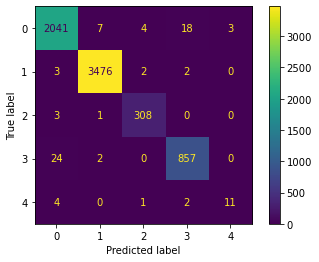

In [85]:
read = open('Experiment_8.json', 'r')
data = json.load(read)
print("Best Parameters Saved:",data)

# Iterating over best parameter values
best = []
for i in data.values():
    best.append(i)

# Closing file
read.close()

activation = best[0]
alpha = best[1]
hidden_layer_sizes = best[2]
learning_rate = best[3]
max_iter = best[4]
solver = best[5]
warm_start = best[6]

start_train = time.time()
clf = MLPClassifier(activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, \
                    learning_rate = learning_rate, max_iter = max_iter, solver = solver, warm_start = warm_start)

# Train the model
clf.fit(train_X, train_y)
stop_train = time.time()
train_time= stop_train - start_train
        
# Test the model
start_test = time.time()
y_pred = clf.predict(test_X)
stop_test = time.time()
test_time= stop_test - start_test

values = calculate_metrics(test_y,y_pred,class_labels)

CMD = ConfusionMatrixDisplay.from_predictions(test_y, y_pred, labels = class_labels)

# Print all the metrics:
for i in range(0,14):
    print(Metrics_Name[i],values[i])

print("\nTrain Time(s)",train_time)
print("Test Time(s)",test_time)

In [86]:
os.system('say "Program run completed."')

0

# END OF THE PROGRAM